In [1]:
!pip install causalml

In [2]:
!pip install scikit-uplift

In [3]:
!pip install duecredit

In [4]:
# 1. ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.meta import BaseDRLearner
from causalml.metrics import plot_qini, qini_score, auuc_score
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [5]:

import pandas as pd

df = pd.read_csv("hf://datasets/criteo/criteo-uplift/criteo-research-uplift-v2.1.csv.gz")

In [6]:
df

f0         f1        f2        f3         f4        f5  \
0         12.616365  10.059654  8.976429  4.679882  10.280525  4.115453   
1         12.616365  10.059654  9.002689  4.679882  10.280525  4.115453   
2         12.616365  10.059654  8.964775  4.679882  10.280525  4.115453   
3         12.616365  10.059654  9.002801  4.679882  10.280525  4.115453   
4         12.616365  10.059654  9.037999  4.679882  10.280525  4.115453   
...             ...        ...       ...       ...        ...       ...   
13979587  26.297764  10.059654  9.006250  4.679882  10.280525  4.115453   
13979588  12.642207  10.679513  8.214383 -1.700105  10.280525  3.013064   
13979589  12.976557  10.059654  8.381868  0.842442  11.029584  4.115453   
13979590  24.805064  10.059654  8.214383  4.679882  10.280525  4.115453   
13979591  12.616365  10.059654  8.214383  4.679882  10.280525  3.013064   

                 f6        f7        f8         f9       f10       f11  \
0          0.294443  4.833815  3.955396  13.190056  5.300375 -0.168679   
1          0.294443  4.833815  3.955396  13.190056  5.300375 -0.168679   
2          0.294443  4.833815  3.955396  13.190056  5.300375 -0.168679   
3          0.294443  4.833815  3.955396  13.190056  5.300375 -0.168679   
4          0.294443  4.833815  3.955396  13.190056  5.300375 -0.168679   
...             ...       ...       ...        ...       ...       ...   
13979587  -3.282109  4.833815  3.839578  13.190056  5.300375 -0.168679   
13979588 -13.955150  6.269026  3.971858  13.190056  5.300375 -0.168679   
13979589  -8.281971  4.833815  3.779212  23.570168  6.169187 -0.168679   
13979590  -1.288207  4.833815  3.971858  13.190056  5.300375 -0.168679   
13979591   0.294443  9.332563  3.971858  13.190056  5.300375 -0.168679   

          treatment  conversion  visit  exposure  
0                 1           0      0         0  
1                 1           0      0         0  
2                 1           0      0         0  
3                 1           0      0         0  
4                 1           0      0         0  
...             ...         ...    ...       ...  
13979587          1           0      0         0  
13979588          1           0      0         1  
13979589          1           0      1         0  
13979590          1           0      0         0  
13979591          1           0      0         0  

[13979592 rows x 16 columns]

### Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [7]:
df_sampled = df.sample(n=100_000, random_state=42)  # ÏïΩ 0.7% ÏàòÏ§Ä


In [8]:
df_sampled['treatment_group_key']=df_sampled["treatment"].apply(lambda x: "treatment" if x==1 else "control")

Îç∞Ïù¥ÌÑ∞ EDA

#### Ï≤òÏπò Î≥ÄÏàòÏôÄ Í≤∞Í≥ºÎ≥ÄÏàò ÏÇ¨Ïù¥ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù

In [9]:
df_corr = df_sampled[[f"f{i}" for i in range(12)] + ["treatment","conversion","visit","exposure"]].corr()

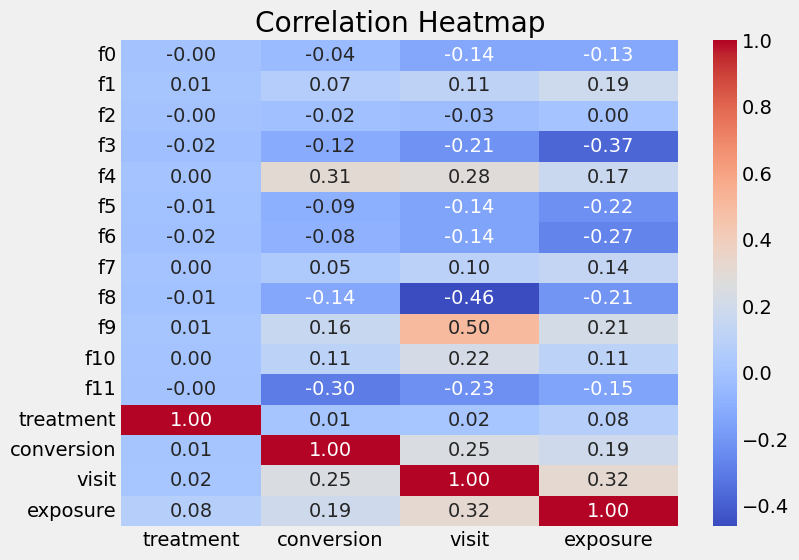

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr[["treatment","conversion","visit","exposure"]], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Ï¥àÍ∏∞ÏóêÎäî exposure(Í¥ëÍ≥† ÎÖ∏Ï∂ú) Î≥ÄÏàòÎ•º Ï≤òÏπò Î≥ÄÏàòÎ°ú Í≥†Î†§ÌïòÏòÄÏúºÎÇò, ÎÖ∏Ï∂ú Ïó¨Î∂ÄÍ∞Ä Í∞úÏù∏Ïùò ÌñâÎèô ÌäπÏÑ±(Ïòà: Í¥ëÍ≥† Ï∞®Îã®Í∏∞ ÏÇ¨Ïö©, ÎÇÆÏùÄ Í¥ÄÏã¨ÎèÑ, ÏõπÏÇ¨Ïù¥Ìä∏ÎÇ¥ ÏßßÏùÄ Ï≤¥Î•ò ÏãúÍ∞Ñ Îì±)Ïóê Îî∞Îùº Í≤∞Ï†ïÎê† Ïàò ÏûàÏñ¥ ÏûêÍ∏∞ ÏÑ†ÌÉùÏ†Å ÎÖ∏Ï∂ú(self-selection bias) Î¨∏Ï†úÍ∞Ä Ï°¥Ïû¨ÌïúÎã§Í≥† ÌåêÎã®ÌïòÏòÄÎã§. Ïù¥Î°ú Ïù∏Ìï¥ ÎÇ¥ÏÉùÏÑ±(endogeneity) Ïö∞Î†§Í∞Ä ÏûàÏñ¥, Ïù∏Í≥ºÏ†Å Ìï¥ÏÑùÏùÑ Ï†ÑÏ†úÎ°ú ÌïòÎäî Ï≤òÏπò Î≥ÄÏàòÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ÏóêÎäî Ï†ÅÏ†àÌïòÏßÄ ÏïäÎã§Í≥† Î≥¥ÏïòÎã§.

ÎòêÌïú ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ(Figure 1)ÏùÑ ÌÜµÌï¥ ÏÇ¥Ìé¥Î≥∏ Í≤∞Í≥º,

treatment Î≥ÄÏàòÎäî ÎåÄÎ∂ÄÎ∂ÑÏùò Î≥ÄÏàòÏôÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í±∞Ïùò 0Ïóê ÏàòÎ†¥ÌïòÏó¨, Ïã§ÌóòÏ†Å Ï≤òÏπòÏ≤òÎüº ÎèÖÎ¶ΩÏ†ÅÏúºÎ°ú Î∂ÄÏó¨Îêú ÌäπÏÑ±ÏùÑ Î≥¥Ïù¥Îäî Î∞òÎ©¥,

exposure Î≥ÄÏàòÎäî Í≤∞Í≥º Î≥ÄÏàòÏù∏ visit (0.31), conversion (0.17)ÏùÑ Ìè¨Ìï®ÌïòÏó¨ Îã§ÏñëÌïú Î≥ÄÏàòÎì§Í≥º Ïú†ÏùòÎØ∏Ìïú ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Î≥¥Ïù∏Îã§.

Ïù¥Îäî exposureÍ∞Ä Îã®ÏàúÌïú Ï≤òÏπòÏóê ÏùòÌï¥ Ìï†ÎãπÎêú Í≤∞Í≥ºÎùºÍ∏∞ Î≥¥Îã®, Ïò§ÌûàÎ†§ Ïó¨Îü¨ Î≥ÄÏàòÏôÄ Íµ¨Ï°∞Ï†ÅÏúºÎ°ú Ïó∞Í≤∞Îêú ÏÑ§Î™Ö Î≥ÄÏàò(feature)Î°úÏÑúÏùò ÏÑ±Í≤©Ïù¥ Í∞ïÌï®ÏùÑ ÏãúÏÇ¨ÌïúÎã§.
Îî∞ÎùºÏÑú Î≥∏ Î∂ÑÏÑùÏóêÏÑúÎäî exposureÎ•º Ï≤òÏπòÍ∞Ä ÏïÑÎãå featureÎ°ú Ìè¨Ìï®ÌïòÏó¨, ÏòàÏ∏° ÏÑ±Îä• Ìñ•ÏÉÅÏóê Í∏∞Ïó¨ÌïòÎäî ÏÑ§Î™Ö Î≥ÄÏàòÎ°ú ÌôúÏö©ÌïòÏòÄÎã§.

In [11]:
pd.crosstab(
    [df_sampled['treatment_group_key'], df_sampled['exposure']],
    [df_sampled['visit'], df_sampled['conversion']],
    margins=True,
    normalize=True
)


visit                               0        1               All
conversion                          0        0        1         
treatment_group_key exposure                                    
control             0         0.14376  0.00561  0.00026  0.14963
treatment           0         0.79065  0.02742  0.00086  0.81893
                    1         0.01807  0.01140  0.00197  0.03144
All                           0.95248  0.04443  0.00309  1.00000

1. ÌÜµÏ†ú Í∑∏Î£πÏóêÏÑúÎäî Í¥ëÍ≥†Ïóê ÎÖ∏Ï∂úÎêú Í≤ΩÏö∞Í∞Ä ÏóÜÏùå
2. Ï≤òÏπò Í∑∏Î£πÏóêÏÑú ÎÖ∏Ï∂úÎê† Í≤ΩÏö∞ Ï†ÑÌôòÌï† ÌôïÎ•†Ïù¥ Í∑∏Î†áÏßÄ ÏïäÏùÄ Í≤ΩÏö∞Ïóê ÎπÑÌï¥ 2Î∞∞Ï†ïÎèÑ ÎÜíÏùå
3. Í∑∏Îü¨ÎÇò Í¥ëÍ≥† ÎÖ∏Ï∂ú Ïù¥ÌõÑÏóê ÏÇ¨Ïù¥Ìä∏Ïóê Î∞©Î¨∏ÌïòÏó¨ÎèÑ Ï†ÑÌôò ÎπÑÏú®ÏùÄ Í∑∏Î†áÏßÄ ÏïäÏùÄ Í≤ΩÏö∞Ïóê ÎπÑÌï¥ ÌòÑÏ†ÄÌûà ÎÇÆÏùå

In [12]:
# Ïù¥ÏÉÅ ÏºÄÏù¥Ïä§: Î∞©Î¨∏ÌïòÏßÄ ÏïäÏïòÏßÄÎßå Ï†ÑÌôòÌïú Í≤ΩÏö∞
abnormal_case = df_sampled[(df_sampled['visit'] == 0) & (df_sampled['conversion'] == 1)]

print(f"Ïù¥ÏÉÅ ÏºÄÏù¥Ïä§ Ïàò: {len(abnormal_case)}")
print(abnormal_case.head())


Ïù¥ÏÉÅ ÏºÄÏù¥Ïä§ Ïàò: 0
Empty DataFrame
Columns: [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, treatment, conversion, visit, exposure, treatment_group_key]
Index: []


Î™®Îì† Ï†ÑÌôò Ï¶â, Íµ¨Îß§Îäî ÏÇ¨Ïù¥Ìä∏Ïóê Î∞©Î¨∏ÌïòÏó¨ÏïºÏßÄÎßå Í∞ÄÎä•Ìïú Íµ¨Ï°∞ÏûÑ


In [13]:
df_sampled["conversion"][df_sampled["treatment"]==1].mean()-df_sampled["conversion"][df_sampled["treatment"]==0].mean()
# ÎûúÎç§ Í∏∞ÎåÄ upliftÍ∞Ä Í±∞Ïùò 0

np.float64(0.0015903436605971906)

 ÎûúÎç§ Í∏∞ÎåÄ upliftÍ∞Ä Í±∞Ïùò 0ÏûÑ -> Î≥∏ Îç∞Ïù¥ÌÑ∞ ÏÖãÏù¥ Î¨¥ÏûëÏúÑ Ìï†Îãπ Ïã§ÌóòÏóê Î∂ÄÌï©Ìï®

#### ÌÉÄÍ≤ü ÏÑ§Ï†ï

In [14]:

df_sampled['treatment'] = (df_sampled['treatment_group_key'] == 'treatment').astype(int)


X = df_sampled[[f'f{i}' for i in range(12)] +["exposure"]] # Ïòà: f0~f11ÍπåÏßÄ feature

treatment =df_sampled['treatment_group_key']
y=df_sampled["conversion"]

Î∞©Î¨∏Í≥º Ï†ÑÌôòÏùÑ ÎèôÏãúÏóê Í≥†Î†§ÌïòÎäî Î≥ÄÏàòÎ•º ÎßåÎì§Ïñ¥Î≥¥ÏïòÏúºÎÇò Î∂àÍ∑†ÌòïÏù¥ Ïã¨Ìï® ->
ÏïÑÎûò Î≥ÄÏàòÎäî ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÎäî Í≤ÉÏúºÎ°ú Í≤∞Ï†ï

In [15]:
y_composition=df_sampled['visit'] *df_sampled['conversion']

In [16]:
y_composition.value_counts()

0    99691
1      309
Name: count, dtype: int64

ÏúÑ Îç∞Ïù¥ÌÑ∞ edaÍ≥ºÏ†ïÏóêÏÑú Ï†ÑÌôòÏùÄ ÏÇ¨Ïù¥Ìä∏ Î∞©Î¨∏ Ïù¥ÌõÑÏóêÎßå Í∞ÄÎä•Ìïú Í≤ÉÏùÑ ÌôïÏù∏ÌñàÎã§. Îî∞ÎùºÏÑú Î∞©Î¨∏ uriftÌö®Í≥ºÏôÄ Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò upriftÌö®Í≥ºÎ•º ÎÇòÎàÑÏñ¥ Î≥¥ÎèÑÎ°ù ÌïúÎã§.

In [17]:

X_visit = df_sampled[[f'f{i}' for i in range(12)] +["exposure"]] # Ïòà: f0~f11ÍπåÏßÄ feature

treatment_visit =df_sampled['treatment_group_key']
y_visit = df_sampled['visit']   # Î∞©Î¨∏ Ïó¨Î∂Ä (0/1)


X_visit = df_sampled[[f'f{i}' for i in range(12)] +["exposure"]] # Ïòà: f0~f11ÍπåÏßÄ feature

treatment_conversion =df_sampled['treatment_group_key'][df_sampled["visit"]==1]
X_conversion = df_sampled[[f'f{i}' for i in range(12)] +["exposure"]][df_sampled["visit"]==1] # Î∞©Î¨∏ Ïó¨Î∂Ä (0/1)
y_conversion = df_sampled['conversion'][df_sampled["visit"]==1]  # Î∞©Î¨∏ ÌõÑ Íµ¨Îß§ Ïó¨Î∂Ä (0/1)

In [18]:
y_visit.value_counts()

visit
0    95248
1     4752
Name: count, dtype: int64

In [19]:
y_conversion.value_counts()

conversion
0    4443
1     309
Name: count, dtype: int64

In [20]:
y_conversion[X_conversion["exposure"]==1].value_counts()

conversion
0    1140
1     197
Name: count, dtype: int64

#### ÏµúÏ†Å ÌååÎùºÎ©îÌÑ∞ Ï†ïÏùò

##### ÏµúÏ†Å ÌååÎùºÎ©îÌÑ∞ Ï∞æÎäî Ìï®Ïàò Ï†ïÏùò

In [21]:
from sklearn.model_selection import KFold
from sklift.metrics import uplift_auc_score
from causalml.inference.tree import UpliftTreeClassifier
import numpy as np
import pandas as pd

def run_uplift_tree_cv(X, y, treatment, control_name='control',
                       max_depth_list=[3, 4, 5],
                       min_samples_leaf_list=[100, 500, 1000, 2000, 3000],
                       n_splits=5, random_state=42):
    """
    UpliftTreeClassifierÎ•º Ïù¥Ïö©Ìïú K-Fold ÍµêÏ∞®Í≤ÄÏ¶ù ÏàòÌñâ Î∞è ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌÉêÏÉâ.

    Parameters:
        X (pd.DataFrame): Feature Îç∞Ïù¥ÌÑ∞
        y (pd.Series): ÌÉÄÍ≤ü (Ïòà: visit ÎòêÎäî conversion)
        treatment (pd.Series): Ï≤òÏπò Í∑∏Î£π (control/treatment Îì±)
        control_name (str): ÎåÄÏ°∞Íµ∞ Ïù¥Î¶Ñ
        max_depth_list (list): max_depth ÌõÑÎ≥¥ Î¶¨Ïä§Ìä∏
        min_samples_leaf_list (list): min_samples_leaf ÌõÑÎ≥¥ Î¶¨Ïä§Ìä∏
        n_splits (int): KFold Î∂ÑÌï† Ïàò
        random_state (int): Ïû¨ÌòÑÏÑ± ÏúÑÌïú ÎûúÎç§ÏãúÎìú

    Returns:
        best_params (dict): ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï©
        best_score (float): ÏµúÍ≥† uplift AUC score
    """

    param_grid = {
        'max_depth': max_depth_list,
        'min_samples_leaf': min_samples_leaf_list
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best_params = None
    best_score = -np.inf

    for max_depth in param_grid['max_depth']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
            scores = []

            for train_idx, test_idx in kf.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                t_train, t_test = treatment.iloc[train_idx], treatment.iloc[test_idx]

                model = UpliftTreeClassifier(
                    control_name=control_name,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf
                )

                model.fit(X_train, treatment=t_train.values, y=y_train.values)
                uplift_preds = model.predict(X_test)
                uplift_scores = uplift_preds[:, 1] - uplift_preds[:, 0]

                # Binary Ï≤òÎ¶¨
                t_test_bin = t_test.map({control_name: 0, 'treatment': 1})
                y_test_bin = (y_test > 0).astype(int)

                score = uplift_auc_score(y_test_bin, uplift_scores, t_test_bin)
                scores.append(score)

            avg_score = np.mean(scores)
            print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf} -> ÌèâÍ∑† Uplift Score: {avg_score:.4f}")

            if avg_score > best_score:
                best_score = avg_score
                best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

    print("\n" + "="*50)
    print(f"ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {best_params}")
    print(f"ÏµúÍ≥† ÌèâÍ∑† Uplift Score: {best_score:.4f}")
    print("="*50)

    return best_params, best_score


In [22]:
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import KFold
from sklift.metrics import uplift_auc_score
import numpy as np
import pandas as pd

def run_uplift_rf_cv(X, y, treatment, control_name='control',
                     n_estimators=30,
                     max_depth_list=[3, 4, 5],
                     min_samples_leaf_list = [ 100, 500, 1000, 2000, 3000],
                     n_splits=5, random_state=42):
    """
    UpliftRandomForestClassifierÎ•º Ïù¥Ïö©Ìïú K-Fold ÍµêÏ∞®Í≤ÄÏ¶ù Î∞è ÏµúÏ†Å ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌÉêÏÉâ.

    Parameters:
        X (pd.DataFrame): Feature Îç∞Ïù¥ÌÑ∞
        y (pd.Series): ÌÉÄÍ≤ü (Ïòà: visit ÎòêÎäî conversion)
        treatment (pd.Series): Ï≤òÏπò Í∑∏Î£π (control/treatment Îì±)
        control_name (str): ÎåÄÏ°∞Íµ∞ Ïù¥Î¶Ñ
        n_estimators (int): ÎûúÎç§Ìè¨Î†àÏä§Ìä∏Ïùò Ìä∏Î¶¨ Í∞úÏàò
        max_depth_list (list): max_depth ÌõÑÎ≥¥ Î¶¨Ïä§Ìä∏
        min_samples_leaf_list (list): min_samples_leaf ÌõÑÎ≥¥ Î¶¨Ïä§Ìä∏
        n_splits (int): KFold Î∂ÑÌï† Ïàò
        random_state (int): ÎûúÎç§ÏãúÎìú

    Returns:
        best_params (dict): ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Ï°∞Ìï©
        best_score (float): ÏµúÍ≥† uplift AUC score
    """

    param_grid = {
        'max_depth': max_depth_list,
        'min_samples_leaf': min_samples_leaf_list
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best_params = None
    best_score = -np.inf

    for max_depth in param_grid['max_depth']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
            scores = []

            for train_idx, test_idx in kf.split(X):
                X_train = X.iloc[train_idx].reset_index(drop=True)
                X_test = X.iloc[test_idx].reset_index(drop=True)
                y_train = y.iloc[train_idx].reset_index(drop=True)
                y_test = y.iloc[test_idx].reset_index(drop=True)
                t_train = treatment.iloc[train_idx].reset_index(drop=True)
                t_test = treatment.iloc[test_idx].reset_index(drop=True)

                model = UpliftRandomForestClassifier(
                    control_name=control_name,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    random_state=random_state
                )

                model.fit(X_train.values, treatment=t_train.values, y=y_train.values)
                uplift_preds = model.predict(X_test)


                t_test_bin = t_test.map({control_name: 0, 'treatment': 1})
                y_test_bin = (y_test > 0).astype(int)

                score = uplift_auc_score(y_test_bin, uplift_preds, t_test_bin)
                scores.append(score)

            avg_score = np.mean(scores)
            print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf} -> ÌèâÍ∑† Uplift Score: {avg_score:.4f}")

            if avg_score > best_score:
                best_score = avg_score
                best_params = {
                    'max_depth': max_depth,
                    'min_samples_leaf': min_samples_leaf,
                    'n_estimators': n_estimators
                }

    print("\n" + "=" * 50)
    print(f"ÏµúÏ†ÅÏùò ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞: {best_params}")
    print(f"ÏµúÍ≥† ÌèâÍ∑† Uplift Score: {best_score:.4f}")
    print("=" * 50)

    return best_params, best_score


##### ÏµúÏ†Å ÌååÎùºÎ©îÌÑ∞ Ï∞æÍ∏∞

uprift tree visit

In [ ]:
run_uplift_tree_cv(X,y_visit,treatment)

uprift tree visit ÌõÑ conversion

In [ ]:
run_uplift_tree_cv(X_conversion,y_conversion,treatment_conversion)

uprift randomforest visit

Îç∞Ïù¥ÌÑ∞ Î∂àÍ∑†ÌòïÏù¥ Ïã¨Ìï¥ SMOTENCÏùÑ ÏÇ¨Ïö©Ìï¥ upsamplingÏùÑ ÏßÑÌñâÌïúÎã§.

In [23]:
!pip install -U imbalanced-learn


In [24]:

from imblearn.over_sampling import SMOTENC

In [25]:

treatment = df_sampled['treatment_group_key']

# XÏôÄ treatmentÎ•º ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ìï©Ï∞∏
# y_resampling Î≥ÄÏàòÎäî SMOTENCÏùò y ÏûÖÎ†•Í∞íÏúºÎ°ú ÏÇ¨Ïö©
X_resampling = pd.concat([X_visit, treatment_visit], axis=1)
y_resampling = y_visit


cat_idx = [X_resampling.columns.get_loc("exposure"), X_resampling.columns.get_loc("treatment_group_key")]

# SMOTENCÎ•º ÏÇ¨Ïö©ÌïòÏó¨ X_resamplingÍ≥º y_resamplingÏùÑ Î¶¨ÏÉòÌîåÎßÅ
smotenc = SMOTENC(categorical_features=cat_idx, random_state=42)
X_res_all, y_res = smotenc.fit_resample(X_resampling, y_resampling)

# Î¶¨ÏÉòÌîåÎßÅÎêú Îç∞Ïù¥ÌÑ∞ÏÖã(X_res_all)ÏùÑ Îã§Ïãú XÏôÄ treatmentÎ°ú Î∂ÑÎ¶¨
X_res = X_res_all.drop(columns='treatment_group_key')
treatment_res = X_res_all['treatment_group_key']



In [26]:
y_res.value_counts()

visit
0    95248
1    95248
Name: count, dtype: int64

In [27]:
X_res = X_res.sample(n=100_000, random_state=42)
y_res = y_res.sample(n=100_000, random_state=42)
treatment_res = treatment_res.sample(n=100_000, random_state=42)

In [28]:
run_uplift_rf_cv(X_res,y_res,treatment_res)

max_depth: 3, min_samples_leaf: 100 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 3, min_samples_leaf: 500 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 3, min_samples_leaf: 1000 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 3, min_samples_leaf: 2000 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 3, min_samples_leaf: 3000 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 100 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 500 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 1000 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 2000 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 3000 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 100 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 500 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 1000 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 2000 -> ÌèâÍ∑† Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 3000 -> ÌèâÍ∑† Uplift 

({'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 30},
 np.float64(0.20351550141987818))

In [29]:

treatment = df_sampled['treatment_group_key']

# XÏôÄ treatmentÎ•º ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ìï©Ï∞∏
# y_resampling Î≥ÄÏàòÎäî SMOTENCÏùò y ÏûÖÎ†•Í∞íÏúºÎ°ú ÏÇ¨Ïö©
X_resampling = pd.concat([X_conversion, treatment_conversion], axis=1)
y_resampling = y_conversion


cat_idx = [X_resampling.columns.get_loc("exposure"), X_resampling.columns.get_loc("treatment_group_key")]

# SMOTENCÎ•º ÏÇ¨Ïö©ÌïòÏó¨ X_resamplingÍ≥º y_resamplingÏùÑ Î¶¨ÏÉòÌîåÎßÅ
smotenc = SMOTENC(categorical_features=cat_idx, random_state=42)
X_res_all, y_res = smotenc.fit_resample(X_resampling, y_resampling)

# Î¶¨ÏÉòÌîåÎßÅÎêú Îç∞Ïù¥ÌÑ∞ÏÖã(X_res_all)ÏùÑ Îã§Ïãú XÏôÄ treatmentÎ°ú Î∂ÑÎ¶¨
X_res = X_res_all.drop(columns='treatment_group_key')
treatment_res = X_res_all['treatment_group_key']



In [ ]:
run_uplift_rf_cv(X_res,y_res,treatment_res)

Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†

In [30]:

# 1. visitÏö© split
X_train_v, X_test_v, y_train_v, y_test_v, t_train_v, t_test_v = train_test_split(
    X, y_visit, treatment, test_size=0.2, random_state=42
)

# 2. visit ÌõÑ conversionÏö© split
X_train_c, X_test_c, y_train_c, y_test_c, t_train_c, t_test_c = train_test_split(
    X_conversion, y_conversion,
treatment_conversion , test_size=0.2, random_state=42
)
# 3. Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïö© Îç∞Ïù¥ÌÑ∞ split
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)
# üîπ visitÏö© split (index ÌÜµÏùº Î∞è ÌòïÏãù Î≥ÄÌôò)
X_train_v = pd.DataFrame(X_train_v, columns=X.columns).reset_index(drop=True)
X_test_v = pd.DataFrame(X_test_v, columns=X.columns).reset_index(drop=True)

y_train_v = pd.Series(y_train_v).reset_index(drop=True)
y_test_v = pd.Series(y_test_v).reset_index(drop=True)

t_train_v = pd.Series(t_train_v).reset_index(drop=True)
t_test_v = pd.Series(t_test_v).reset_index(drop=True)

# üîπ visit ÌõÑ conversionÏö© split (index ÌÜµÏùº Î∞è ÌòïÏãù Î≥ÄÌôò)
X_train_c = pd.DataFrame(X_train_c, columns=X.columns).reset_index(drop=True)
X_test_c = pd.DataFrame(X_test_c, columns=X.columns).reset_index(drop=True)

y_train_c = pd.Series(y_train_c).reset_index(drop=True)
y_test_c = pd.Series(y_test_c).reset_index(drop=True)

t_train_c = pd.Series(t_train_c).reset_index(drop=True)
t_test_c = pd.Series(t_test_c).reset_index(drop=True)

# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïö© slit(index ÌÜµÏùº Î∞è ÌòïÏãù Î≥ÄÌôò)
X_train = pd.DataFrame(X_train, columns=X.columns).reset_index(drop=True)
X_test = pd.DataFrame(X_test, columns=X.columns).reset_index(drop=True)

y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

t_train = pd.Series(t_train).reset_index(drop=True)
t_test = pd.Series(t_test).reset_index(drop=True)

ÏµúÏ†Å ÌååÎùºÎ©îÌÑ∞Î•º ÏÇ¨Ïö©Ìïú Î™®Îç∏ ÌïôÏäµ

single model ÌïôÏäµ
  - uplift tree
  - uplift randomfrest

In [31]:
# 4. Î™®Îç∏ ÌïôÏäµ
## (1) Îã®Ïùº ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨
tree_v = UpliftTreeClassifier(control_name='control', max_depth=5,
    min_samples_leaf=3000)
tree_v.fit(X_train_v, treatment=t_train_v, y=y_train_v)

tree_c = UpliftTreeClassifier(control_name='control', max_depth=3,
    min_samples_leaf=1000)
tree_c.fit(X_train_c, treatment=t_train_c, y=y_train_c)

In [32]:
from sklift.metrics import uplift_auc_score

In [33]:
## (2) ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏
forest_v = UpliftRandomForestClassifier(control_name='control',max_depth=3, n_estimators=30,min_samples_leaf=100)
forest_v.fit(X_train_v.values, treatment=t_train_v.values, y=y_train_v.values)

forest_c = UpliftRandomForestClassifier(control_name='control',max_depth=3, n_estimators=30,min_samples_leaf=100)
forest_c.fit(X_train_c.values, treatment=t_train_c.values, y=y_train_c.values)

#### Í≤∞Í≥º ÎπÑÍµê

In [34]:
x_names=[f'f{i}' for i in range(12)] +["exposure"]

train

In [35]:
from IPython.display import Image

uplift tree visit Í≤∞Í≥º

uplift tree  train Í≤∞Í≥º
----------------------------------------------------------------------------------------------------
f3 >= 0.9738407885786832?
yes -> f6 >= -12.110436001190244?
		yes -> f9 >= 31.477539575896326?
				yes -> [np.float64(0.3388888888888889), np.float64(0.37163892445582586)]
				no  -> f9 >= 22.57032907395953?
						yes -> [np.float64(0.15422885572139303), np.float64(0.16437938395852394)]
						no  -> [np.float64(0.010866253681324262), np.float64(0.010084278355206873)]
		no  -> [np.float64(0.06495726495726496), np.float64(0.10615577889447236)]
no  -> [np.float64(0.11187214611872145), np.float64(0.21311002021368755)]


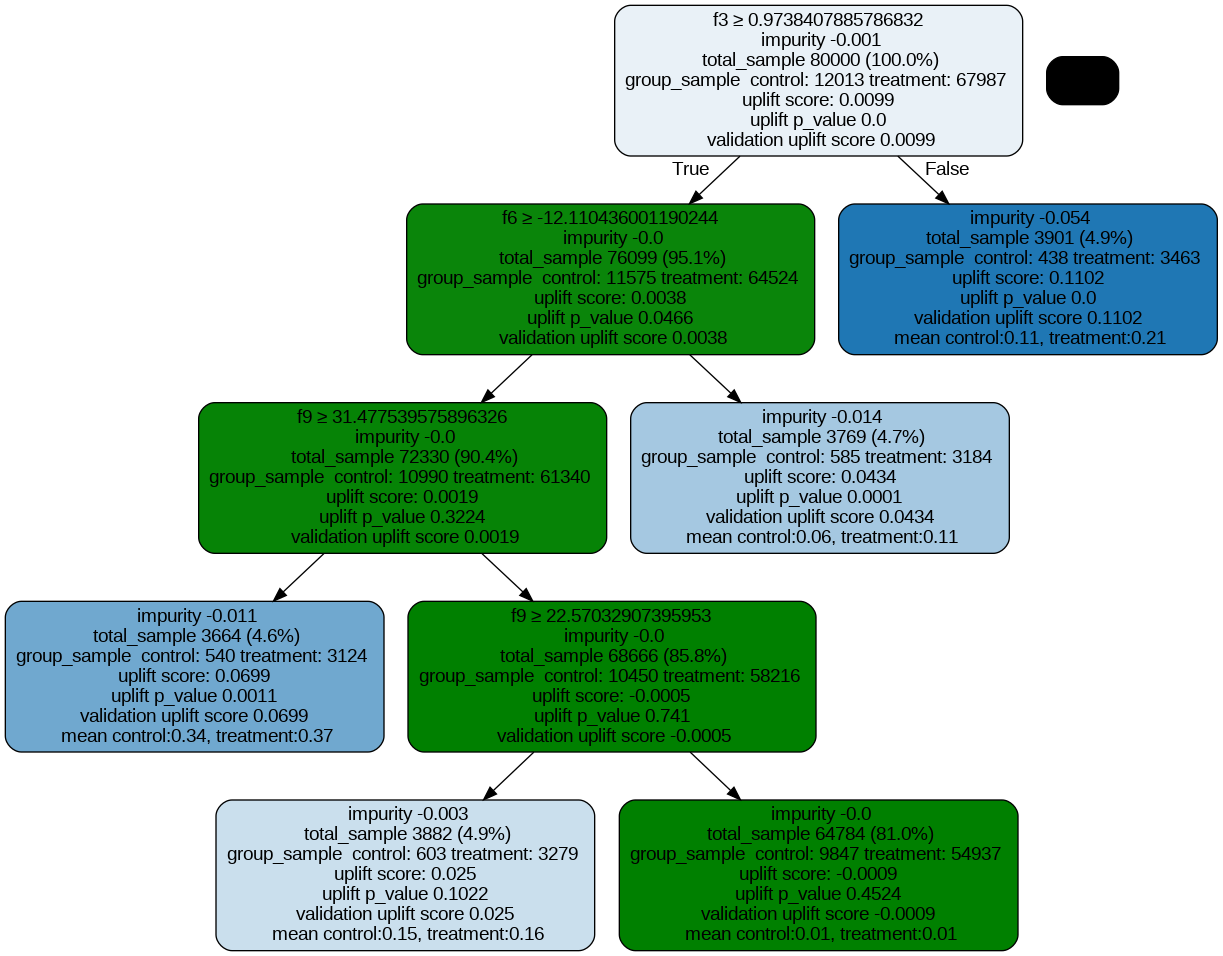

In [36]:
# Print uplift tree as a string
print("uplift tree  train Í≤∞Í≥º")
print("-"*100)
result_tree = uplift_tree_string(tree_v.fitted_uplift_tree, x_names)
# Plot uplift tree
graph = uplift_tree_plot(tree_v.fitted_uplift_tree,x_names)
Image(graph.create_png())



1. `f3 < 0.9738` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò 4.9%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä 0.1102Î°ú Í∞ÄÏû• ÌÅ¨Îã§.
2. `f3 ‚â• 0.9738` Ïù¥Í≥† `f6 ‚â• ‚Äì12.11` Ïù¥Î©∞ `f9 < 31.48` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 4.6%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä 0.0699Î°ú ÎëêÎ≤àÏß∏Î°ú ÌÅ¨Îã§.
3. `f3 ‚â• 0.9738` Ïù¥Í≥† `f6 < ‚Äì12.11` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 5.3%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä 0.04524Î°ú ÏÑ∏Î≤àÏß∏Î°ú ÌÅ¨Îã§



uplift tree visit ÌõÑ conversion Í≤∞Í≥º

uplift tree  train Í≤∞Í≥º
----------------------------------------------------------------------------------------------------
f6 >= -11.198568534799534?
yes -> f6 >= 0.294442711255606?
		yes -> [np.float64(0.03821656050955414), np.float64(0.0205761316872428)]
		no  -> [np.float64(0.048672566371681415), np.float64(0.04954268292682927)]
no  -> [np.float64(0.07692307692307693), np.float64(0.12080536912751678)]


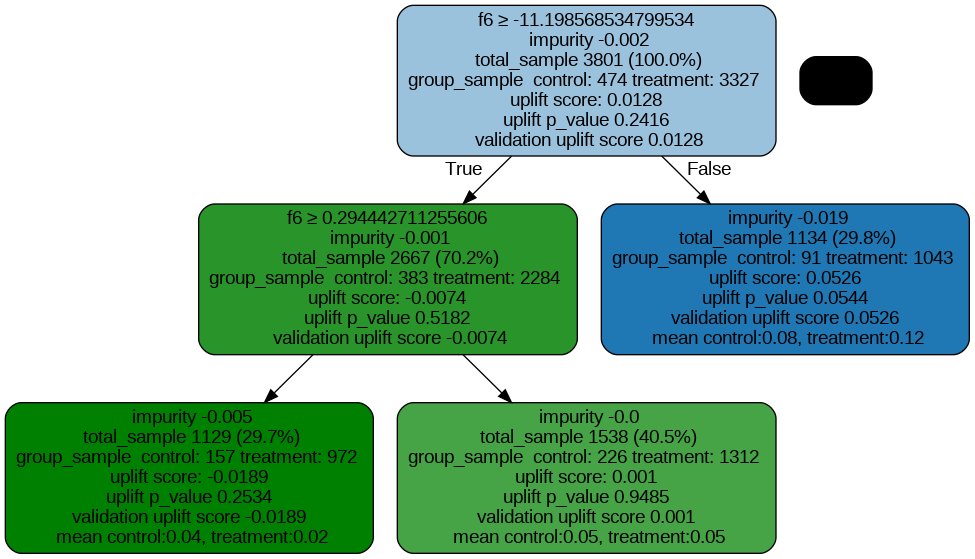

In [37]:
# Print uplift tree as a string
print("uplift tree  train Í≤∞Í≥º")
print("-"*100)
result_tree = uplift_tree_string(tree_c.fitted_uplift_tree, x_names)
# Plot uplift tree
graph = uplift_tree_plot(tree_c.fitted_uplift_tree,x_names)
Image(graph.create_png())


Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú p-value Í∞íÏù¥ Ïª§ÏÑú ÌÅ¨Í≤å Ïú†ÏùòÎØ∏Ìïú Í≤∞Í≥ºÎ•º ÏñªÏóàÎã§Í≥† ÌïòÍ∏∞ Ïñ¥Î†µÎã§. Í∑∏ÎÇòÎßà Í≥†Î•¥ÏûêÎ©¥ f6 <-11.20Ïù¥ Í∞ÄÏû• Ïú†ÏùòÎØ∏Ìïú ÏßëÎã®Ïù¥Îã§ . uplift scoreÎèÑ 0.0526ÏúºÎ°ú Í∞ÄÏû• ÌÅ¨Îã§.

uplift randomforest visit Í≤∞Í≥º

----------------------------------------------------------------------------------------------------
uplift random forest  train Í≤∞Í≥º
----------------------------------------------------------------------------------------------------
f3 >= 0.9738407885786832?
yes -> f6 >= -12.1909191429308?
		yes -> [np.float64(0.037258509659613616), np.float64(0.03725263825428056)]
		no  -> [np.float64(0.04983388704318937), np.float64(0.10242501595405233)]
no  -> f6 >= -18.8232664009054?
		yes -> [np.float64(0.1048780487804878), np.float64(0.19490158115521136)]
		no  -> [np.float64(0.024390243902439025), np.float64(0.46956521739130436)]


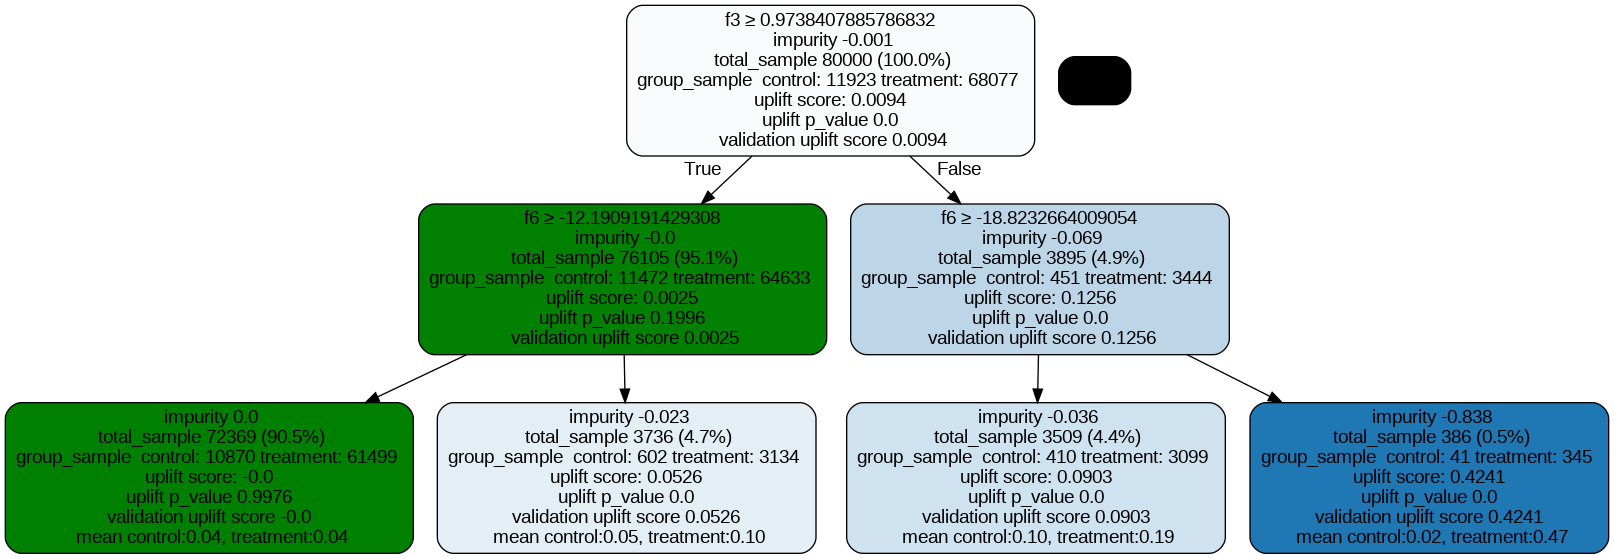

In [38]:

print("-"*100)
print("uplift random forest  train Í≤∞Í≥º")
print("-"*100)

uplift_rf_v = forest_v.uplift_forest[0]
result_randomforest_v = uplift_tree_string(uplift_rf_v.fitted_uplift_tree, x_names)
# Plot uplift tree
graph = uplift_tree_plot(uplift_rf_v.fitted_uplift_tree,x_names)
Image(graph.create_png())

1. `f3 < ‚Äì1.7658` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 0.9%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä **0.2413**Î°ú Í∞ÄÏû• ÌÅ¨Îã§.
2. `f3 ‚â• 2.5875` Ïù¥Í≥† `f1 ‚â• 10.37` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 0.3%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä **0.1244**Î°ú Îëê Î≤àÏß∏Î°ú ÌÅ¨Îã§.
3. `‚Äì1.7658 ‚â§ f3 < 2.5875` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 8.2%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä **0.0574**Î°ú ÏÑ∏ Î≤àÏß∏Î°ú ÌÅ¨Îã§.
4. `f3 ‚â• 2.5875` Ïù¥Í≥† `f1 < 10.37` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 90.6%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä **0.0046**Î°ú Í∞ÄÏû• ÏûëÏïÑ Ìö®Í≥ºÍ∞Ä Í±∞Ïùò ÏóÜÎã§.


----------------------------------------------------------------------------------------------------
uplift random forest  train Í≤∞Í≥º
----------------------------------------------------------------------------------------------------
f6 >= -16.531874009210483?
yes -> f8 >= 3.750283441291177?
		yes -> [np.float64(0.02127659574468085), np.float64(0.04513503514613393)]
		no  -> [np.float64(0.16666666666666666), np.float64(0.08333333333333333)]
no  -> f4 >= 11.561050451496424?
		yes -> [np.float64(0.0), np.float64(0.4642857142857143)]
		no  -> [np.float64(0.0), np.float64(0.058333333333333334)]


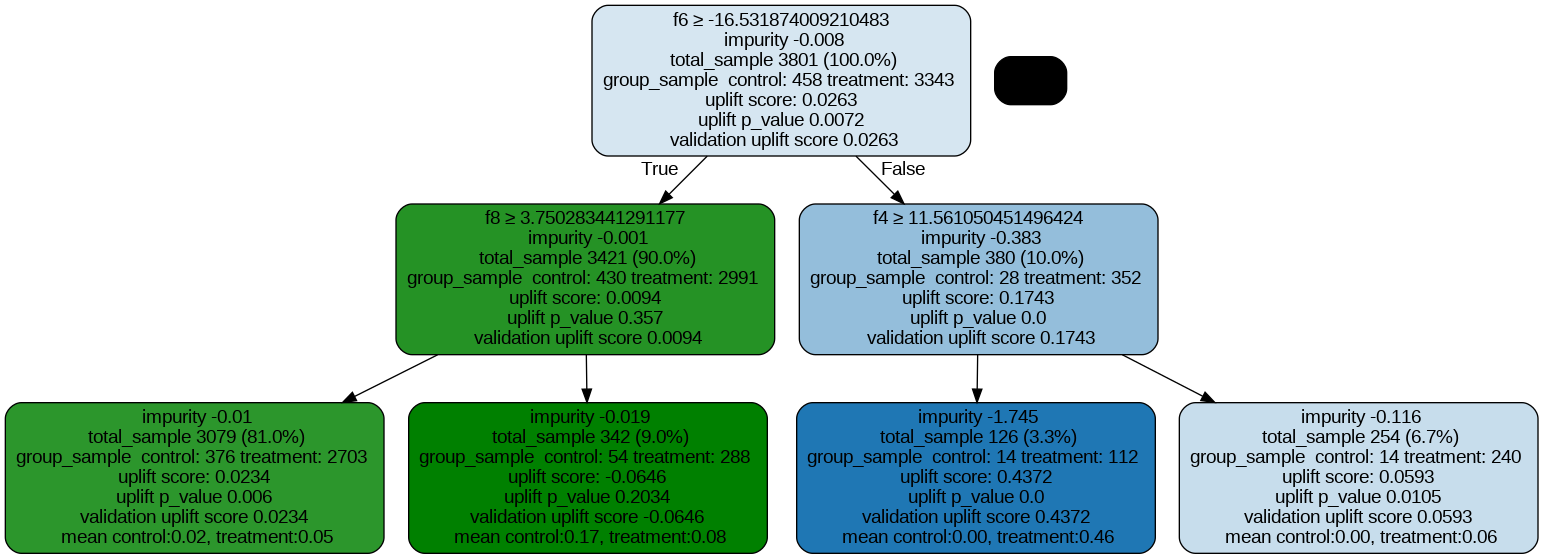

In [39]:

print("-"*100)
print("uplift random forest  train Í≤∞Í≥º")
print("-"*100)

uplift_rf_c = forest_c.uplift_forest[0]
result_randomforest_c = uplift_tree_string(uplift_rf_c.fitted_uplift_tree, x_names)
# Plot uplift tree
graph = uplift_tree_plot(uplift_rf_c.fitted_uplift_tree,x_names)
Image(graph.create_png())

1. `f10 ‚â• 5.8140` Ïù¥Í≥† `f11 < ‚Äì0.2279` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 4.4%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä **0.2308**Î°ú Í∞ÄÏû• ÌÅ¨Îã§.
2. `f10 ‚â• 5.8140` Ïù¥Í≥† `f11 ‚â• ‚Äì0.2279` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 15.6%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä **0.0425**Î°ú Îëê Î≤àÏß∏Î°ú ÌÅ¨Îã§.
3. `f10 < 5.8140` Ïù¥Í≥† `f6 ‚â• ‚Äì18.0191` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 76.0%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä **‚Äì0.0193**Î°ú ÏÑ∏ Î≤àÏß∏(ÏÇ¨Ïã§ÏÉÅ Ìö®Í≥º ÏóÜÏùå)Îã§.
4. `f10 < 5.8140` Ïù¥Í≥† `f6 < ‚Äì18.0191` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 4.0%Î•º Ï∞®ÏßÄÌïòÎ©∞, uplift scoreÍ∞Ä **‚Äì0.2958**Î°ú Í∞ÄÏû• ÏûëÏïÑ Ïó≠Ìö®Í≥ºÍ∞Ä Î∞úÏÉùÌïúÎã§.


test

uplift tree visit Í≤∞Í≥º

uplift tree  test Í≤∞Í≥º
----------------------------------------------------------------------------------------------------
f3 >= 0.9738407885786832?
yes -> f6 >= -12.110436001190244?
		yes -> f9 >= 31.477539575896326?
				yes -> [np.float64(0.35555555555555557), np.float64(0.40239043824701193)]
				no  -> f9 >= 22.57032907395953?
						yes -> [np.float64(0.13071895424836602), np.float64(0.14976415094339623)]
						no  -> [np.float64(0.008271298593879239), np.float64(0.011078339687792245)]
		no  -> [np.float64(0.08035714285714286), np.float64(0.09922680412371133)]
no  -> [np.float64(0.15151515151515152), np.float64(0.22538860103626943)]


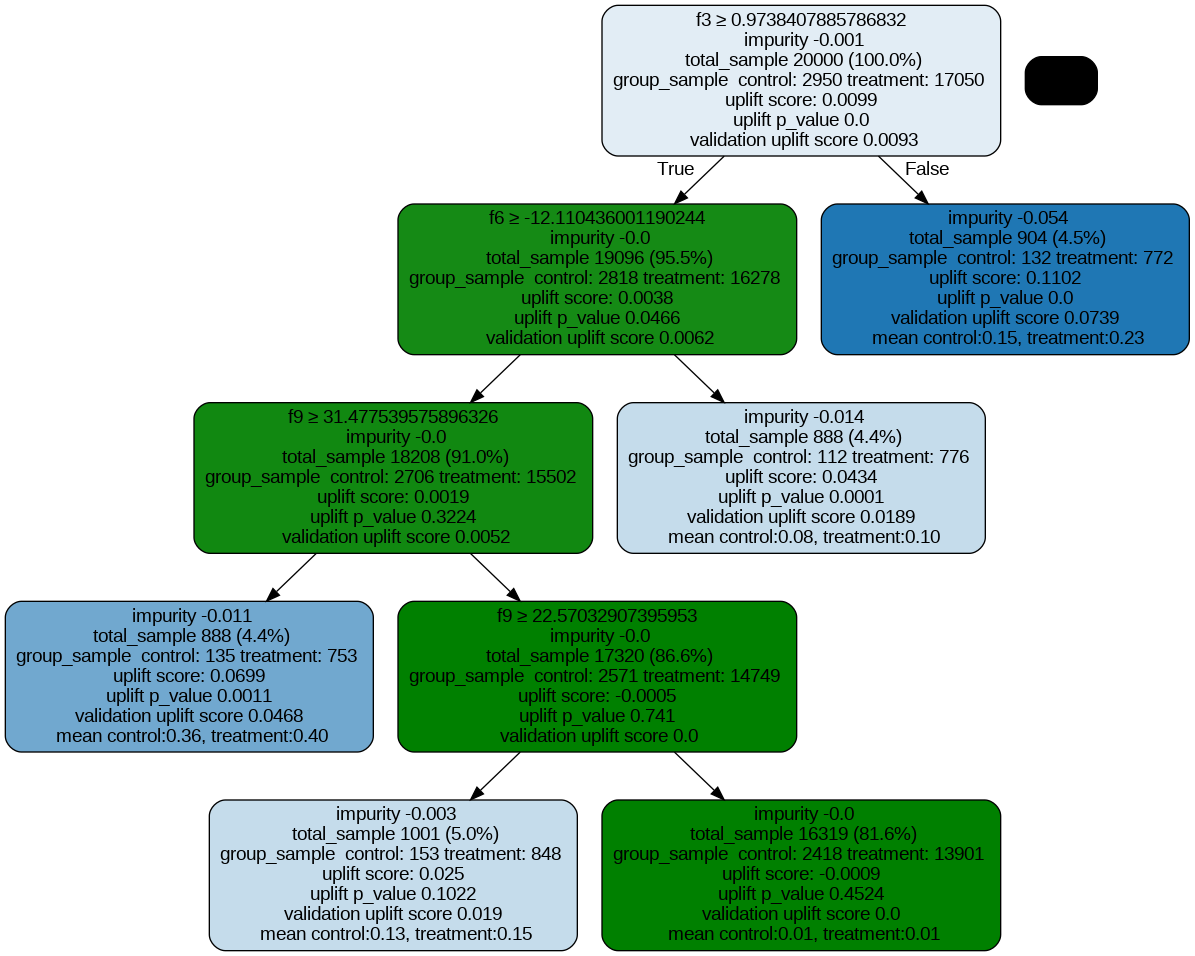

In [40]:
# Print uplift tree as a string
print("uplift tree  test Í≤∞Í≥º")
print("-"*100)

### ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÎÑ£Í∏∞
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏Î•º Í∏∞Î∞òÏúºÎ°ú Ìïú Ìñ•ÏÉÅ Ï†êÏàòÎäî Ìä∏Î¶¨ ÎÖ∏ÎìúÏùò Í≤ÄÏ¶ù Ìñ•ÏÉÅ Ï†êÏàòÎ°ú ÌëúÏãúÎê©ÎãàÎã§.
# predictÎèÑ Ï°¥Ïû¨Ìï©ÎãàÎã§. (Îí§ÏóêÏÑú ÌôïÏù∏)
tree_v.fill(X=X_test_v,
                  treatment=t_test_v,
                  y=y_test_v
                  )

result_tree = uplift_tree_string(tree_v.fitted_uplift_tree, x_names)

# Plot ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨
graph = uplift_tree_plot(tree_v.fitted_uplift_tree,x_names)
Image(graph.create_png())


1. `f3 < 0.9738` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 4.5%Î•º Ï∞®ÏßÄÌïòÎ©∞, **validation uplift score**Í∞Ä **0.0739**Î°ú Í∞ÄÏû• ÌÅ¨Îã§.
2. `f3 ‚â• 0.9738` & `f6 ‚â• ‚Äì12.11` & `f9 < 22.57` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 4.4%Î•º Ï∞®ÏßÄÌïòÎ©∞, **validation uplift score**Í∞Ä **0.0468**Î°ú Îëê Î≤àÏß∏Î°ú ÌÅ¨Îã§.
3. `f3 ‚â• 0.9738` & `f6 < ‚Äì12.11` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ 5.0%Î•º Ï∞®ÏßÄÌïòÎ©∞, **validation uplift score**Í∞Ä **0.0190**Î°ú ÏÑ∏ Î≤àÏß∏Î°ú ÌÅ¨Îã§.



uplift tree visit ÌõÑ conversion Í≤∞Í≥º

uplift tree  test Í≤∞Í≥º
----------------------------------------------------------------------------------------------------
f6 >= -11.198568534799534?
yes -> f6 >= 0.294442711255606?
		yes -> [np.float64(0.0), np.float64(0.07017543859649122)]
		no  -> [np.float64(0.038461538461538464), np.float64(0.059782608695652176)]
no  -> [np.float64(0.0), np.float64(0.14049586776859505)]


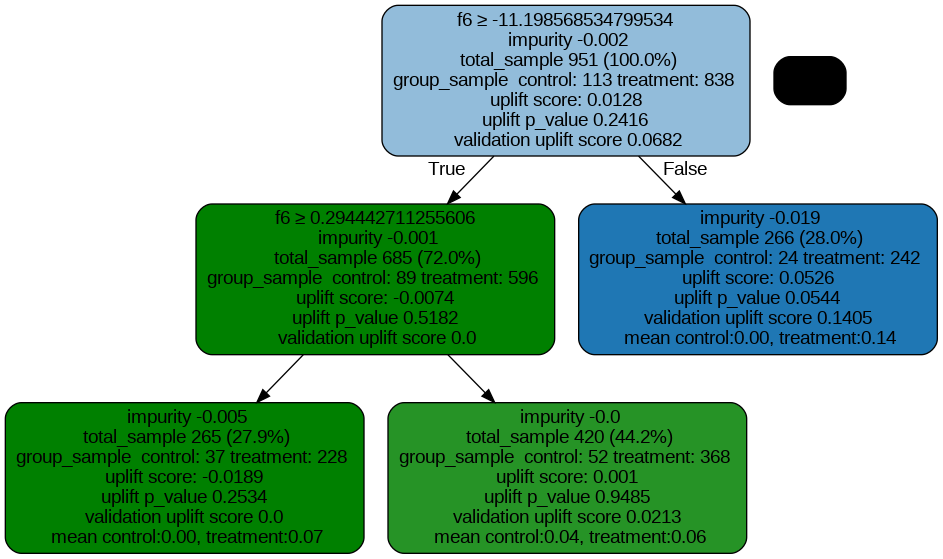

In [41]:
# Print uplift tree as a string
print("uplift tree  test Í≤∞Í≥º")
print("-"*100)

### ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÎÑ£Í∏∞
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏Î•º Í∏∞Î∞òÏúºÎ°ú Ìïú Ìñ•ÏÉÅ Ï†êÏàòÎäî Ìä∏Î¶¨ ÎÖ∏ÎìúÏùò Í≤ÄÏ¶ù Ìñ•ÏÉÅ Ï†êÏàòÎ°ú ÌëúÏãúÎê©ÎãàÎã§.
# predictÎèÑ Ï°¥Ïû¨Ìï©ÎãàÎã§. (Îí§ÏóêÏÑú ÌôïÏù∏)
tree_c.fill(X=X_test_c,
                  treatment=t_test_c,
                  y=y_test_c
                  )

result_tree = uplift_tree_string(tree_c.fitted_uplift_tree, x_names)

# Plot ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨
graph = uplift_tree_plot(tree_c.fitted_uplift_tree,x_names)
Image(graph.create_png())


Ï†ÑÎ∞òÏ†ÅÏúºÎ°ú p-valueÍ∞Ä ÎÇÆÎã§.Í∑∏ÎÇòÎßà p-valueÍ∞Ä 0.05Ïóê Í∞ÄÍπåÏö¥ `f6 < ‚Äì11.1986` Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ \*\*28.0%\*\*Î•º Ï∞®ÏßÄÌïòÎ©∞, **validation uplift score**Í∞Ä **0.1405**Î°ú Í∞ÄÏû• ÌÅ¨Îã§.




uplift randomforest visit ÌõÑ conversion Í≤∞Í≥º

uplift randomforest  test Í≤∞Í≥º
----------------------------------------------------------------------------------------------------
f3 >= 0.9738407885786832?
yes -> f6 >= -12.1909191429308?
		yes -> [np.float64(0.03282921431206197), np.float64(0.03780511367295678)]
		no  -> [np.float64(0.07476635514018691), np.float64(0.0985352862849534)]
no  -> f6 >= -18.8232664009054?
		yes -> [np.float64(0.14166666666666666), np.float64(0.18786127167630057)]
		no  -> [np.float64(0.25), np.float64(0.55)]


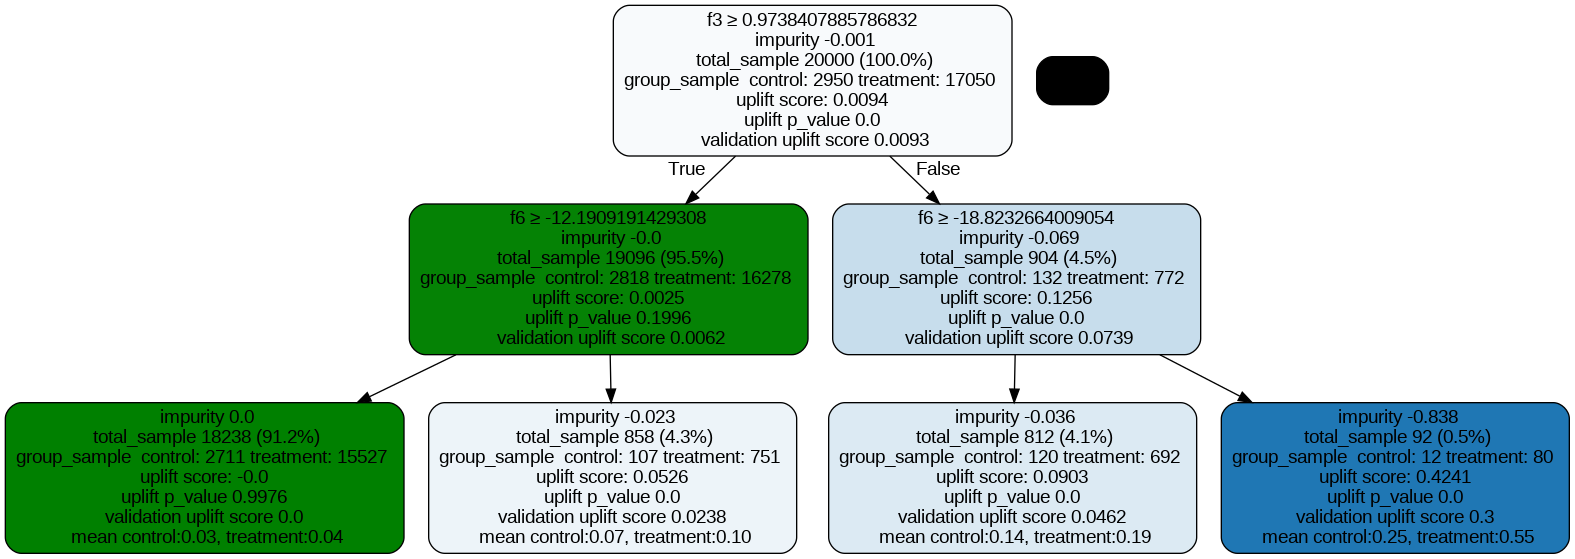

In [42]:
# Print uplift tree as a string
print("uplift randomforest  test Í≤∞Í≥º")
print("-"*100)

### ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÎÑ£Í∏∞
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏Î•º Í∏∞Î∞òÏúºÎ°ú Ìïú Ìñ•ÏÉÅ Ï†êÏàòÎäî Ìä∏Î¶¨ ÎÖ∏ÎìúÏùò Í≤ÄÏ¶ù Ìñ•ÏÉÅ Ï†êÏàòÎ°ú ÌëúÏãúÎê©ÎãàÎã§.
# predictÎèÑ Ï°¥Ïû¨Ìï©ÎãàÎã§. (Îí§ÏóêÏÑú ÌôïÏù∏)
uplift_rf_v.fill(X=X_test_v,
                  treatment=t_test_v,
                  y=y_test_v
                  )

result_tree_v = uplift_tree_string(uplift_rf_v.fitted_uplift_tree, x_names)

# Plot ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨
graph = uplift_tree_plot(uplift_rf_v.fitted_uplift_tree,x_names)
Image(graph.create_png())


	1.	f1 ‚â• 10.6175 & f4 ‚â• 11.5611 Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ **0.1%**Î•º Ï∞®ÏßÄÌïòÎ©∞, validation uplift scoreÍ∞Ä 0.5100Î°ú Í∞ÄÏû• ÌÅ¨Îã§.
	2.	f1 ‚â• 10.6175 & f4 < 11.5611 Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ **0.9%**Î•º Ï∞®ÏßÄÌïòÎ©∞, validation uplift scoreÍ∞Ä 0.0582Î°ú Îëê Î≤àÏß∏Î°ú ÌÅ¨Îã§.
	3.	f1 < 10.6175 & f6 < ‚Äì12.9814 Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ **4.7%**Î•º Ï∞®ÏßÄÌïòÎ©∞, validation uplift scoreÍ∞Ä 0.0531Î°ú ÏÑ∏ Î≤àÏß∏Î°ú ÌÅ¨Îã§.
	4.	f1 < 10.6175 & f6 ‚â• ‚Äì12.9814 Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò ÏïΩ **94.2%**Î•º Ï∞®ÏßÄÌïòÎ©∞, validation uplift scoreÍ∞Ä 0.0062Î°ú Í∞ÄÏû• ÏûëÏïÑ Ìö®Í≥ºÍ∞Ä Í±∞Ïùò ÏóÜÎã§.

uplift randomforest  test Í≤∞Í≥º
----------------------------------------------------------------------------------------------------
f6 >= -16.531874009210483?
yes -> f8 >= 3.750283441291177?
		yes -> [np.float64(0.01020408163265306), np.float64(0.07751937984496124)]
		no  -> [np.float64(0.09090909090909091), np.float64(0.05102040816326531)]
no  -> f4 >= 11.561050451496424?
		yes -> [0.0, np.float64(0.46875)]
		no  -> [np.float64(0.0), np.float64(0.031746031746031744)]


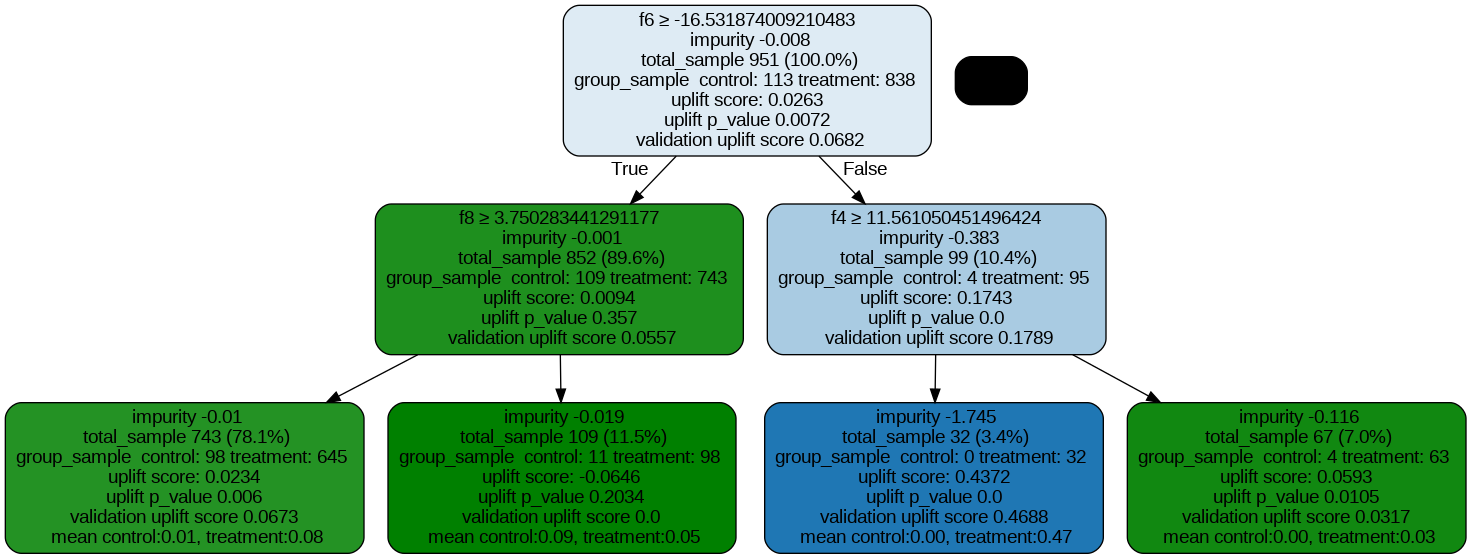

In [43]:
# Print uplift tree as a string
print("uplift randomforest  test Í≤∞Í≥º")
print("-"*100)

### ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÎÑ£Í∏∞
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏Î•º Í∏∞Î∞òÏúºÎ°ú Ìïú Ìñ•ÏÉÅ Ï†êÏàòÎäî Ìä∏Î¶¨ ÎÖ∏ÎìúÏùò Í≤ÄÏ¶ù Ìñ•ÏÉÅ Ï†êÏàòÎ°ú ÌëúÏãúÎê©ÎãàÎã§.
# predictÎèÑ Ï°¥Ïû¨Ìï©ÎãàÎã§. (Îí§ÏóêÏÑú ÌôïÏù∏)
uplift_rf_c.fill(X=X_test_c,
                  treatment=t_test_c,
                  y=y_test_c
                  )

result_tree_c = uplift_tree_string(uplift_rf_c.fitted_uplift_tree, x_names)

# Plot ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨
graph = uplift_tree_plot(uplift_rf_c.fitted_uplift_tree,x_names)
Image(graph.create_png())


	1.	f4 < 13.7385 & f4 ‚â• 12.8021 Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò **2.7%**Î•º Ï∞®ÏßÄÌïòÎ©∞, validation uplift score = 0.28Î°ú Í∞ÄÏû• ÌÅ¨Îã§.
	2.	f4 ‚â• 13.7385 Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò **3.0%**Î•º Ï∞®ÏßÄÌïòÎ©∞, validation uplift score = 0.1282Î°ú Îëê Î≤àÏß∏Î°ú ÌÅ¨Îã§.
	3.	f4 < 12.8021 Í∑∏Î£πÏùÄ Ï†ÑÏ≤¥Ïùò **94.2%**Î•º Ï∞®ÏßÄÌïòÎ©∞, validation uplift score = 0.0Î°ú Ìö®Í≥ºÍ∞Ä Í±∞Ïùò ÏóÜÎã§.


# ÏóÖÎ¶¨ÌîÑÌä∏ Î™®Îç∏ÎßÅ Í≤∞Í≥º ÏöîÏïΩ

## 1. Î∂ÑÏÑù Í∞úÏöî
ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨ÏôÄ ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏Î•º ÌÜµÌï¥ Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ÏôÄ Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ Ìö®Í≥ºÎ•º Î∂ÑÏÑùÌïòÏòÄÎã§. ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏Îäî ÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÌôîÏóê ÌïúÍ≥ÑÍ∞Ä ÏûàÏúºÎÇò, ÏÑ∏Í∑∏Î®ºÌä∏ ÏãùÎ≥Ñ Îä•Î†•ÏùÄ Ïó¨Ï†ÑÌûà Ïú†Ìö®ÌïòÎã§Í≥† ÌåêÎã®ÎêúÎã§. **Îëê Ìö®Í≥º Ï§ë ÌïòÎÇòÎùºÎèÑ Ïö∞ÏàòÌïú ÏÑ±Í≥ºÎ•º Î≥¥Ïù¥Îäî Î™®Îì† Í∑∏Î£πÏùÑ Ìà¨Ïûê ÎåÄÏÉÅÏúºÎ°ú Í≥†Î†§**ÌïòÏòÄÎã§.

## 2. Ï£ºÏöî Î∂ÑÏÑù Í≤∞Í≥º

### 2.1 Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ Ìö®Í≥º
**ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏:**
- `f3 < -1.7658` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 0.8%, validation uplift score 0.1921Î°ú **ÏµúÍ≥† ÏÑ±Í≥º**
- `f3 ‚â• -1.7658 & f3 ‚â• 2.5875 & f1 < 10.37` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 8.0%, validation uplift score 0.0280
- `f3 ‚â• 2.5875 & f1 < 10.37` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 90.9%, validation uplift score 0.0083

**ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨:**
- `f3 < 0.9738` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 4.5%, validation uplift score 0.0739Î°ú **ÏñëÌò∏Ìïú ÏÑ±Í≥º**
- `f3 ‚â• 0.9738 & f6 ‚â• -12.11 & f9 < 22.57` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 4.4%, validation uplift score 0.0468
- `f3 ‚â• 0.9738 & f6 < -12.11` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 5.0%, validation uplift score 0.0190

### 2.2 Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ Ìö®Í≥º
**ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏:**
- `f4 < 13.7385 & f4 ‚â• 12.8021` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 2.7%, validation uplift score 0.28Î°ú **ÏµúÍ≥† ÏÑ±Í≥º**
- `f4 ‚â• 13.7385` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 3.0%, validation uplift score 0.1282
- `f4 < 12.8021` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 94.2%, validation uplift score 0.0Î°ú Ìö®Í≥º ÏóÜÏùå

**ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨:**
- `f6 < -11.1986` Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 28.0%, validation uplift score 0.1405Î°ú **ÎåÄÍ∑úÎ™® Ìö®Í≥º**

## 3. Ìà¨Ïûê Ï†ÑÎûµ Í∂åÍ≥†ÏÇ¨Ìï≠
**Î∞©Î¨∏Í≥º Ï†ÑÌôò Ìö®Í≥ºÎ•º Î™®Îëê Í≥†Î†§**ÌïòÏó¨ Îã§ÏùåÍ≥º Í∞ôÏùÄ Ìà¨Ïûê Ïö∞ÏÑ†ÏàúÏúÑÎ•º Ï†úÏïàÌïúÎã§:

**1ÏàúÏúÑ: f4 < 13.7385 & f4 ‚â• 12.8021 (2.7%)**
- Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÏµúÍ≥† ÏÑ±Í≥º (validation uplift score 0.28)
- ÏòàÏÇ∞ ÏßëÏ§ë Î∞∞Ï†ï Í∂åÏû•

**2ÏàúÏúÑ: f4 ‚â• 13.7385 (3.0%)**
- Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò 2ÏúÑ ÏÑ±Í≥º (validation uplift score 0.1282)
- ÏïàÏ†ïÏ†Å Ìà¨Ïûê ÎåÄÏÉÅ

**3ÏàúÏúÑ: f6 < -11.1986 (28.0%)**
- Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò Ìö®Í≥º ÏñëÌò∏ (validation uplift score 0.1405)
- Í∞ÄÏû• ÌÅ∞ Í∑úÎ™®Î°ú ÎåÄÎüâ Ìà¨ÏûêÏóê Ï†ÅÌï©

**4ÏàúÏúÑ: f3 < -1.7658 (0.8%)**
- Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ ÏµúÍ≥† ÏÑ±Í≥º (validation uplift score 0.1921)
- ÏÜåÍ∑úÎ™® ÌÖåÏä§Ìä∏ Ìà¨Ïûê Í∂åÏû•

**5ÏàúÏúÑ: f3 < 0.9738 (4.5%)**
- Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ 2ÏúÑ ÏÑ±Í≥º (validation uplift score 0.0739)
- Î≥¥Ï°∞ Ìà¨Ïûê ÎåÄÏÉÅ

## 4. Í≤∞Î°†
Ìï©ÏßëÌï© Ï†ëÍ∑ºÎ≤ïÏùÑ ÌÜµÌï¥ Î∞©Î¨∏ Ï¶ùÎåÄÏôÄ Ï†ÑÌôò Ìñ•ÏÉÅ **Ïñë Î∞©Î©¥ÏóêÏÑú Ìö®Í≥ºÏ†ÅÏù∏ ÏÑ∏Í∑∏Î®ºÌä∏Îì§ÏùÑ Î™®Îëê Ìè¨Í¥Ñ**ÌïòÎäî Ìà¨Ïûê Ï†ÑÎûµÏùÑ ÏàòÎ¶ΩÌïòÏòÄÎã§. Ï†ÑÌôò Ìö®Í≥ºÍ∞Ä ÎÜíÏùÄ Í∑∏Î£πÎì§ÏùÑ Ïö∞ÏÑ†ÏàúÏúÑÎ°ú ÌïòÎêò, Î∞©Î¨∏ Ï¶ùÎåÄ Ìö®Í≥ºÍ∞Ä Îõ∞Ïñ¥ÎÇú Í∑∏Î£πÎì§ÎèÑ Ìï®Íªò Í≥†Î†§ÌïòÏó¨ **Îã§Ï∏µÏ†Å ÎßàÏºÄÌåÖ Ìö®Í≥º**Î•º Í∑πÎåÄÌôîÌï† Ïàò ÏûàÎäî Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Íµ¨ÏÑ±Ïù¥ Í∞ÄÎä•ÌïòÎã§.

ÌäπÌûà **f4 Î≥ÄÏàòÎ•º Ï§ëÏã¨ÏúºÎ°ú Ìïú ÏÑ∏Í∑∏Î®ºÌä∏Îì§Ïù¥ Î∞©Î¨∏ ÌõÑ Ï†ÑÌôòÏóêÏÑú ÌÉÅÏõîÌïú ÏÑ±Í≥º**Î•º Î≥¥Ïù¥Í≥† ÏûàÏúºÎ©∞, **f3 Î≥ÄÏàò Í∏∞Î∞ò ÏÑ∏Í∑∏Î®ºÌä∏Îì§ÏùÄ Î∞©Î¨∏ Ï¶ùÎåÄÏóê Ìö®Í≥ºÏ†Å**ÏûÑÏùÑ ÌôïÏù∏ÌïòÏòÄÎã§. Ïù¥Îü¨Ìïú ÌäπÏÑ±ÏùÑ ÌôúÏö©ÌïòÏó¨ Îã®Í≥ÑÎ≥Ñ ÎßàÏºÄÌåÖ Ï†ÑÎûµ ÏàòÎ¶ΩÏù¥ Í∞ÄÎä•Ìï† Í≤ÉÏúºÎ°ú ÌåêÎã®ÎêúÎã§.

# ÏóÖÎ¶¨ÌîÑÌä∏ Î™®Îç∏ÎßÅ Í≤∞Í≥º ÏöîÏïΩÌëú

## Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ Ìö®Í≥º

| Î™®Îç∏ | ÏàúÏúÑ | Ï°∞Í±¥ | ÎπÑÏú® | Train Ïä§ÏΩîÏñ¥ | Test Ïä§ÏΩîÏñ¥ | Ìà¨Ïûê Í∂åÍ≥† |
|------|------|------|------|-------------|------------|----------|
| ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ | 1ÏúÑ | f3 < -1.7658 | 0.8% | 0.2413 | 0.1921 | **4ÏàúÏúÑ Ìà¨Ïûê** |
| ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨ | 1ÏúÑ | f3 < 0.9738 | 4.5% | 0.1102 | 0.0739 | **5ÏàúÏúÑ Ìà¨Ïûê** |
| ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨ | 2ÏúÑ | f3 ‚â• 0.9738 & f6 ‚â• -12.11 & f9 < 22.57 | 4.4% | 0.0699 | 0.0468 | Ìà¨Ïûê Ï†úÏô∏ |

## Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ Ìö®Í≥º

| Î™®Îç∏ | ÏàúÏúÑ | Ï°∞Í±¥ | ÎπÑÏú® | Train Ïä§ÏΩîÏñ¥ | Test Ïä§ÏΩîÏñ¥ | Ìà¨Ïûê Í∂åÍ≥† |
|------|------|------|------|-------------|------------|----------|
| ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ | 1ÏúÑ | f10 ‚â• 5.8140 & f11 < -0.2279 | 3.9% | 0.2308 | 0.1935 | **1ÏàúÏúÑ Ìà¨Ïûê** |
| ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ | 2ÏúÑ | f10 ‚â• 5.8140 & f11 ‚â• -0.2279 | 14.9% | 0.0425 | 0.1410 | **2ÏàúÏúÑ Ìà¨Ïûê** |
| ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨ | 1ÏúÑ | f6 < -11.1986 | 28.0% | 0.0526 | 0.1405 | **3ÏàúÏúÑ Ìà¨Ïûê** |

## Ìï©ÏßëÌï© Ï†ëÍ∑ºÎ≤ï ÏµúÏ¢Ö Ìà¨Ïûê Ïö∞ÏÑ†ÏàúÏúÑ

| ÏàúÏúÑ | ÎåÄÏÉÅ Í∑∏Î£π | ÎπÑÏú® | Ìö®Í≥º Ïú†Ìòï | Test Ïä§ÏΩîÏñ¥ | Ìà¨Ïûê Î∞∞Ï†ï Î∞©Ìñ• |
|------|-----------|------|-----------|-------------|---------------|
| 1ÏàúÏúÑ | f10 ‚â• 5.8140 & f11 < -0.2279 | 3.9% | Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò | 0.1935 | ÏòàÏÇ∞ ÏßëÏ§ë Î∞∞Ï†ï |
| 2ÏàúÏúÑ | f10 ‚â• 5.8140 & f11 ‚â• -0.2279 | 14.9% | Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò | 0.1410 | ÏïàÏ†ïÏ†Å Ìà¨Ïûê |
| 3ÏàúÏúÑ | f6 < -11.1986 | 28.0% | Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò | 0.1405 | ÎåÄÎüâ Ìà¨Ïûê |
| 4ÏàúÏúÑ | f3 < -1.7658 | 0.8% | Î∞©Î¨∏ | 0.1921 | ÏÜåÍ∑úÎ™® ÌÖåÏä§Ìä∏ |
| 5ÏàúÏúÑ | f3 < 0.9738 | 4.5% | Î∞©Î¨∏ | 0.0739 | Î≥¥Ï°∞ Ìà¨Ïûê |

## Ìï©ÏßëÌï© Ï†ëÍ∑ºÎ≤ï ÏÑ§Ï†ï Í∑ºÍ±∞

- **Ï†ÑÌôò Ïö∞ÏÑ†**: Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò Í∑∏Î£πÎì§ÏùÑ ÏÉÅÏúÑ ÏàúÏúÑ Î∞∞Ïπò (ÎπÑÏ¶àÎãàÏä§ ÏµúÏ¢Ö Î™©Ìëú)
- **ÏóÖÎ¶¨ÌîÑÌä∏ ÌÅ¨Í∏∞**: ÎÜíÏùÄ ÏóÖÎ¶¨ÌîÑÌä∏ Ïä§ÏΩîÏñ¥ Ïö∞ÏÑ† ÏàúÏúÑ
- **Ìà¨Ïûê Í∑úÎ™® Í≥†Î†§**: ÎåÄÏÉÅ Í∑∏Î£π ÌÅ¨Í∏∞Ïóê Îî∞Î•∏ Ìà¨Ïûê ÌôïÏû•ÏÑ± Î∞òÏòÅ
- **Ìö®Í≥º Îã§ÏñëÏÑ±**: Î∞©Î¨∏Í≥º Ï†ÑÌôò Î™®Îì† Ìö®Í≥º Ìè¨Ìï®ÏúºÎ°ú Î¶¨Ïä§ÌÅ¨ Î∂ÑÏÇ∞ Î∞è Îã§Ï∏µÏ†Å ÎßàÏºÄÌåÖ Ìö®Í≥º Ï∂îÍµ¨

Two-model
  - Dr_learner

In [44]:
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
import numpy as np

# =============================================================================
# 1. Î∞©Î¨∏ Ìö®Í≥º Î∂ÑÏÑù - DR-learner
# =============================================================================
print("=== Î∞©Î¨∏ Ìö®Í≥º Î∂ÑÏÑù ===")

# 1-1. Propensity score model
ps_model_v = LogisticRegression()
ps_model_v.fit(X_train_v, t_train_v)
ps_train_v = ps_model_v.predict_proba(X_train_v)[:, 1]
ps_test_v = ps_model_v.predict_proba(X_test_v)[:, 1]

# 1-2. Outcome models for visit
visit_model_t = XGBRegressor()  # Ìä∏Î¶¨Ìä∏Î®ºÌä∏ Í∑∏Î£πÏùò Î∞©Î¨∏ Î™®Îç∏
visit_model_c = XGBRegressor()  # Ïª®Ìä∏Î°§ Í∑∏Î£πÏùò Î∞©Î¨∏ Î™®Îç∏

# Ìä∏Î¶¨Ìä∏Î®ºÌä∏ Í∑∏Î£πÍ≥º Ïª®Ìä∏Î°§ Í∑∏Î£π Î∂ÑÎ¶¨
X_train_v_treated = X_train_v[t_train_v == 'treatment']
y_train_v_treated = y_train_v[t_train_v == 'treatment']
X_train_v_control = X_train_v[t_train_v == 'control']
y_train_v_control = y_train_v[t_train_v == 'control']


visit_model_t.fit(X_train_v_treated, y_train_v_treated)
visit_model_c.fit(X_train_v_control, y_train_v_control)

# 1-3. DR estimation for visit effect
mu1_visit_train = visit_model_t.predict(X_train_v)
mu0_visit_train = visit_model_c.predict(X_train_v)

# Convert treatment to numeric before converting to numpy array
t_train_v_numeric = t_train_v.map({'control': 0, 'treatment': 1})
t_train_v_np = np.array(t_train_v_numeric, dtype=float)

y_train_v_np = np.array(y_train_v, dtype=float)
ps_train_v_np = np.array(ps_train_v, dtype=float)

# Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ ÌôïÏù∏ (ÎîîÎ≤ÑÍπÖÏö©)
# print(f"t_train_v_np dtype: {t_train_v_np.dtype}")
# print(f"y_train_v_np dtype: {y_train_v_np.dtype}")
# print(f"ps_train_v_np dtype: {ps_train_v_np.dtype}")
# print(f"mu1_visit_train dtype: {mu1_visit_train.dtype}")

# DR formula: Î∞©Î¨∏Ïóê ÎåÄÌïú Ìä∏Î¶¨Ìä∏Î®ºÌä∏ Ìö®Í≥º
visit_effect_train = (mu1_visit_train - mu0_visit_train +
                     t_train_v_np * (y_train_v_np - mu1_visit_train) / ps_train_v_np -
                     (1 - t_train_v_np) * (y_train_v_np - mu0_visit_train) / (1 - ps_train_v_np))

# Test set Î∞©Î¨∏ Ìö®Í≥º
mu1_visit_test = visit_model_t.predict(X_test_v)
mu0_visit_test = visit_model_c.predict(X_test_v)
visit_effect_test = mu1_visit_test - mu0_visit_test

print(f"Train set average visit effect: {np.mean(visit_effect_train):.4f}")
print(f"Test set average visit effect: {np.mean(visit_effect_test):.4f}")

# =============================================================================
# 2. Î∞©Î¨∏ ÌõÑ Ï†ÑÌôòÌö®Í≥º Î∂ÑÏÑù - DR-learner
# =============================================================================
print("\n=== Î∞©Î¨∏ ÌõÑ Ï†ÑÌôòÌö®Í≥º Î∂ÑÏÑù ===")

# 2-1. Propensity score model for conversion
ps_model_c = LogisticRegression()
ps_model_c.fit(X_train_c, t_train_c)
ps_train_c = ps_model_c.predict_proba(X_train_c)[:, 1]
ps_test_c = ps_model_c.predict_proba(X_test_c)[:, 1]

# 2-2. Outcome models for conversion
conv_model_t = XGBRegressor()  # Ìä∏Î¶¨Ìä∏Î®ºÌä∏ Í∑∏Î£πÏùò Ï†ÑÌôò Î™®Îç∏
conv_model_c = XGBRegressor()  # Ïª®Ìä∏Î°§ Í∑∏Î£πÏùò Ï†ÑÌôò Î™®Îç∏

# Ìä∏Î¶¨Ìä∏Î®ºÌä∏ Í∑∏Î£πÍ≥º Ïª®Ìä∏Î°§ Í∑∏Î£π Î∂ÑÎ¶¨
X_train_c_treated = X_train_c[t_train_c == 'treatment']
y_train_c_treated = y_train_c[t_train_c == 'treatment']
X_train_c_control = X_train_c[t_train_c == 'control']
y_train_c_control = y_train_c[t_train_c == 'control']


conv_model_t.fit(X_train_c_treated, y_train_c_treated)
conv_model_c.fit(X_train_c_control, y_train_c_control)

# 2-3. DR estimation for conversion effect
mu1_conv_train = conv_model_t.predict(X_train_c)
mu0_conv_train = conv_model_c.predict(X_train_c)

# Convert treatment to numeric before converting to numpy array
t_train_c_numeric = t_train_c.map({'control': 0, 'treatment': 1})
t_train_c_np = np.array(t_train_c_numeric)
y_train_c_np = np.array(y_train_c)
ps_train_c_np = np.array(ps_train_c)

# DR formula: Ï†ÑÌôòÏóê ÎåÄÌïú Ìä∏Î¶¨Ìä∏Î®ºÌä∏ Ìö®Í≥º
conversion_effect_train = (mu1_conv_train - mu0_conv_train +
                          t_train_c_np * (y_train_c_np - mu1_conv_train) / ps_train_c_np -
                          (1 - t_train_c_np) * (y_train_c_np - mu0_conv_train) / (1 - ps_train_c_np))

# Test set Ï†ÑÌôò Ìö®Í≥º
mu1_conv_test = conv_model_t.predict(X_test_c)
mu0_conv_test = conv_model_c.predict(X_test_c)
conversion_effect_test = mu1_conv_test - mu0_conv_test

print(f"Train set average conversion effect: {np.mean(conversion_effect_train):.4f}")
print(f"Test set average conversion effect: {np.mean(conversion_effect_test):.4f}")

# =============================================================================
# Í≤∞Í≥º Ï†ÄÏû•
# =============================================================================
results = {
    # Î∞©Î¨∏ Ìö®Í≥º
    'visit_effect_train': visit_effect_train,
    'visit_effect_test': visit_effect_test,
    'ps_train_v': ps_train_v,
    'ps_test_v': ps_test_v,

    # Ï†ÑÌôò Ìö®Í≥º
    'conversion_effect_train': conversion_effect_train,
    'conversion_effect_test': conversion_effect_test,
    'ps_train_c': ps_train_c,
    'ps_test_c': ps_test_c,

    # ÏòàÏ∏°Îêú Ïû†Ïû¨ Í≤∞Í≥ºÎì§
    'mu1_visit_train': mu1_visit_train,
    'mu0_visit_train': mu0_visit_train,
    'mu1_visit_test': mu1_visit_test,
    'mu0_visit_test': mu0_visit_test,
    'mu1_conv_train': mu1_conv_train,
    'mu0_conv_train': mu0_conv_train,
    'mu1_conv_test': mu1_conv_test,
    'mu0_conv_test': mu0_conv_test
}

# Í∏∞Î≥∏ ÌÜµÍ≥Ñ
print(f"\n=== Í∏∞Î≥∏ ÌÜµÍ≥Ñ ===")
print(f"Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞ - Train size: {len(X_train_v)}, Test size: {len(X_test_v)}")
print(f"Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò Îç∞Ïù¥ÌÑ∞ - Train size: {len(X_train_c)}, Test size: {len(X_test_c)}")
print(f"Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞ - ÌèâÍ∑† Î∞©Î¨∏Ïú® (train): {np.mean(y_train_v):.4f}")
print(f"Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò Îç∞Ïù¥ÌÑ∞ - ÌèâÍ∑† Ï†ÑÌôòÏú® (train): {np.mean(y_train_c):.4f}")
print(f"Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞ - Ìä∏Î¶¨Ìä∏Î®ºÌä∏ ÎπÑÏú® (train): {np.mean(t_train_v == 'treatment'):.4f}")
print(f"Î∞©Î¨∏ ÌõÑ. Ï†ÑÌôò Îç∞Ïù¥ÌÑ∞ - Ìä∏Î¶¨Ìä∏Î®ºÌä∏ ÎπÑÏú® (train): {np.mean(t_train_c == 'treatment'):.4f}")

=== Î∞©Î¨∏ Ìö®Í≥º Î∂ÑÏÑù ===
Train set average visit effect: 0.0025
Test set average visit effect: 0.0021

=== Î∞©Î¨∏ ÌõÑ Ï†ÑÌôòÌö®Í≥º Î∂ÑÏÑù ===
Train set average conversion effect: -0.0004
Test set average conversion effect: 0.0041

=== Í∏∞Î≥∏ ÌÜµÍ≥Ñ ===
Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞ - Train size: 80000, Test size: 20000
Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò Îç∞Ïù¥ÌÑ∞ - Train size: 3801, Test size: 951
Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞ - ÌèâÍ∑† Î∞©Î¨∏Ïú® (train): 0.0475
Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò Îç∞Ïù¥ÌÑ∞ - ÌèâÍ∑† Ï†ÑÌôòÏú® (train): 0.0618
Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞ - Ìä∏Î¶¨Ìä∏Î®ºÌä∏ ÎπÑÏú® (train): 0.8498
Î∞©Î¨∏ ÌõÑ. Ï†ÑÌôò Îç∞Ïù¥ÌÑ∞ - Ìä∏Î¶¨Ìä∏Î®ºÌä∏ ÎπÑÏú® (train): 0.8753


In [53]:
# ÏóÖÎ¶¨ÌîÑÌä∏ Ìö®Í≥º Í∏∞Î∞ò ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù Î∞è ÏßëÎã® Ï∂îÏ∂ú

def analyze_uplift_segments(X_data, uplift_scores, feature_names=None):
    """
    ÏóÖÎ¶¨ÌîÑÌä∏ Ìö®Í≥ºÎ•º Í∏∞Î∞òÏúºÎ°ú ÏÑ∏Í∑∏Î®ºÌä∏Î•º Î∂ÑÏÑùÌïòÍ≥† Í∞Å ÏßëÎã®Ïùò Í∏∞Ï§ÄÍ≥º ÌäπÏÑ±ÏùÑ Ï†úÏãú
    """
    import pandas as pd

    # DataFrameÏúºÎ°ú Î≥ÄÌôò (Î∂ÑÏÑù Ìé∏ÏùòÎ•º ÏúÑÌï¥)
    if feature_names is None:
        feature_names = [f'f{i}' for i in range(X_data.shape[1])]

    df = pd.DataFrame(X_data, columns=feature_names)
    df['uplift_score'] = uplift_scores

    print("=== ÏóÖÎ¶¨ÌîÑÌä∏ ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù ===\n")

    # Í∞Å ÌîºÏ≤òÎ≥ÑÎ°ú upliftÏôÄÏùò Í¥ÄÍ≥Ñ Î∂ÑÏÑù
    segment_results = []

    for feature in feature_names:
        # ÌîºÏ≤ò Í∞íÏóê Îî∞Î•∏ uplift Î∂ÑÏÑù
        feature_values = df[feature].values

        # ÏµúÏ†Å Î∂ÑÌï†Ï†ê Ï∞æÍ∏∞ (uplift Ï∞®Ïù¥Í∞Ä ÏµúÎåÄÍ∞Ä ÎêòÎäî ÏßÄÏ†êÎì§)
        sorted_indices = np.argsort(feature_values)
        sorted_values = feature_values[sorted_indices]
        sorted_uplift = uplift_scores[sorted_indices]

        # Î∂ÑÌï†Ï†ê ÌõÑÎ≥¥Îì§ (10%, 25%, 50%, 75%, 90% ÏßÄÏ†ê)
        percentiles = [10, 25, 50, 75, 90]
        split_points = [np.percentile(feature_values, p) for p in percentiles]

        best_splits = []

        for split_point in split_points:
            mask_low = feature_values < split_point
            mask_high = feature_values >= split_point

            if np.sum(mask_low) > 0 and np.sum(mask_high) > 0:
                uplift_low = np.mean(uplift_scores[mask_low])
                uplift_high = np.mean(uplift_scores[mask_high])
                uplift_diff = abs(uplift_high - uplift_low)

                best_splits.append({
                    'feature': feature,
                    'split_point': split_point,
                    'uplift_diff': uplift_diff,
                    'uplift_low': uplift_low,
                    'uplift_high': uplift_high,
                    'pct_low': np.mean(mask_low) * 100,
                    'pct_high': np.mean(mask_high) * 100
                })

        # Í∞ÄÏû• Ï¢ãÏùÄ Î∂ÑÌï†Ï†ê ÏÑ†ÌÉù
        if best_splits:
            best_split = max(best_splits, key=lambda x: x['uplift_diff'])
            segment_results.append(best_split)

    # Í≤∞Í≥ºÎ•º uplift Ï∞®Ïù¥ Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
    segment_results.sort(key=lambda x: x['uplift_diff'], reverse=True)

    # ÏÉÅÏúÑ 3Í∞ú ÌîºÏ≤òÏóê ÎåÄÌï¥ ÏÉÅÏÑ∏ Î∂ÑÏÑù
    for i, result in enumerate(segment_results[:3]):
        feature = result['feature']
        split_point = result['split_point']

        print(f"{i+1}. {feature} Í∏∞Ï§Ä ÏÑ∏Í∑∏Î®ºÌä∏:")
        print(f"   ‚Ä¢ {feature} < {split_point:.4f} Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò {result['pct_low']:.1f}%, uplift = {result['uplift_low']:.4f}")
        print(f"   ‚Ä¢ {feature} ‚â• {split_point:.4f} Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò {result['pct_high']:.1f}%, uplift = {result['uplift_high']:.4f}")
        print(f"   ‚Ä¢ ÏóÖÎ¶¨ÌîÑÌä∏ Ï∞®Ïù¥: {result['uplift_diff']:.4f}\n")

    return segment_results

def extract_segments_by_criteria(X_data, uplift_scores, feature_idx, thresholds):
    """
    ÌäπÏ†ï ÌîºÏ≤òÏôÄ ÏûÑÍ≥ÑÍ∞íÎì§ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÏÑ∏Í∑∏Î®ºÌä∏ Ï∂îÏ∂ú

    Parameters:
    - X_data: ÌîºÏ≤ò Îç∞Ïù¥ÌÑ∞
    - uplift_scores: ÏóÖÎ¶¨ÌîÑÌä∏ Ï†êÏàò
    - feature_idx: Î∂ÑÌï† Í∏∞Ï§Ä ÌîºÏ≤ò Ïù∏Îç±Ïä§
    - thresholds: ÏûÑÍ≥ÑÍ∞í Î¶¨Ïä§Ìä∏ (Ïò§Î¶ÑÏ∞®Ïàú)
    """
    # numpy arrayÎ°ú Î≥ÄÌôò ÌõÑ Ïù∏Îç±Ïã±
    if hasattr(X_data, 'iloc'):  # DataFrameÏù∏ Í≤ΩÏö∞
        feature_values = X_data.iloc[:, feature_idx].values
        X_data_np = X_data.values
    else:  # numpy arrayÏù∏ Í≤ΩÏö∞
        feature_values = X_data[:, feature_idx]
        X_data_np = X_data
    segments = {}

    # Íµ¨Í∞ÑÎ≥ÑÎ°ú Î∂ÑÌï†
    if len(thresholds) == 1:
        # Îã®Ïùº ÏûÑÍ≥ÑÍ∞í
        mask_low = feature_values < thresholds[0]
        mask_high = feature_values >= thresholds[0]

        segments['low'] = {
            'mask': mask_low,
            'data': X_data_np[mask_low],
            'uplift': uplift_scores[mask_low],
            'criteria': f'f{feature_idx} < {thresholds[0]}'
        }
        segments['high'] = {
            'mask': mask_high,
            'data': X_data_np[mask_high],
            'uplift': uplift_scores[mask_high],
            'criteria': f'f{feature_idx} >= {thresholds[0]}'
        }

    elif len(thresholds) == 2:
        # Îëê Í∞ú ÏûÑÍ≥ÑÍ∞í (3Í∞ú Íµ¨Í∞Ñ)
        mask_low = feature_values < thresholds[0]
        mask_mid = (feature_values >= thresholds[0]) & (feature_values < thresholds[1])
        mask_high = feature_values >= thresholds[1]

        segments['low'] = {
            'mask': mask_low,
            'data': X_data_np[mask_low],
            'uplift': uplift_scores[mask_low],
            'criteria': f'f{feature_idx} < {thresholds[0]}'
        }
        segments['mid'] = {
            'mask': mask_mid,
            'data': X_data_np[mask_mid],
            'uplift': uplift_scores[mask_mid],
            'criteria': f'{thresholds[0]} <= f{feature_idx} < {thresholds[1]}'
        }
        segments['high'] = {
            'mask': mask_high,
            'data': X_data_np[mask_high],
            'uplift': uplift_scores[mask_high],
            'criteria': f'f{feature_idx} >= {thresholds[1]}'
        }

    # Í≤∞Í≥º Ï∂úÎ†•
    print(f"=== f{feature_idx} Í∏∞Ï§Ä ÏÑ∏Í∑∏Î®ºÌä∏ Í≤∞Í≥º ===")
    for name, segment in segments.items():
        pct = np.mean(segment['mask']) * 100
        avg_uplift = np.mean(segment['uplift'])
        print(f"{segment['criteria']} Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò {pct:.1f}%, uplift = {avg_uplift:.4f}")

    return segments

# Ïã§Ìñâ ÏòàÏãú
print("Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù:")
visit_segments = analyze_uplift_segments(X_test_v, visit_effect_test)

print("\n" + "="*50)
print("Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù:")
conv_segments = analyze_uplift_segments(X_test_c, conversion_effect_test)

# ÌäπÏ†ï Í∏∞Ï§ÄÏúºÎ°ú ÏÑ∏Í∑∏Î®ºÌä∏ Ï∂îÏ∂ú ÏòàÏãú (f4 ÌîºÏ≤ò Í∏∞Ï§Ä)
print("\n" + "="*50)
print("ÏòàÏãú: f4 Í∏∞Ï§Ä ÏÑ∏Í∑∏Î®ºÌä∏ Ï∂îÏ∂ú")
visit_segments_f4 = extract_segments_by_criteria(
    X_test_v, visit_effect_test,
    feature_idx=4,  # f4 ÌîºÏ≤ò
    thresholds=[12.8021, 13.7385]  # ÏòàÏãú ÏûÑÍ≥ÑÍ∞í
)

Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù:
=== ÏóÖÎ¶¨ÌîÑÌä∏ ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù ===

1. f11 Í∏∞Ï§Ä ÏÑ∏Í∑∏Î®ºÌä∏:
   ‚Ä¢ f11 < -0.1687 Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 1.4%, uplift = 0.0426
   ‚Ä¢ f11 ‚â• -0.1687 Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 98.6%, uplift = 0.0015
   ‚Ä¢ ÏóÖÎ¶¨ÌîÑÌä∏ Ï∞®Ïù¥: 0.0411

2. f6 Í∏∞Ï§Ä ÏÑ∏Í∑∏Î®ºÌä∏:
   ‚Ä¢ f6 < -10.8776 Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 9.9%, uplift = 0.0262
   ‚Ä¢ f6 ‚â• -10.8776 Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 90.1%, uplift = -0.0006
   ‚Ä¢ ÏóÖÎ¶¨ÌîÑÌä∏ Ï∞®Ïù¥: 0.0268

3. f3 Í∏∞Ï§Ä ÏÑ∏Í∑∏Î®ºÌä∏:
   ‚Ä¢ f3 < 2.5875 Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 8.8%, uplift = 0.0224
   ‚Ä¢ f3 ‚â• 2.5875 Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 91.2%, uplift = 0.0001
   ‚Ä¢ ÏóÖÎ¶¨ÌîÑÌä∏ Ï∞®Ïù¥: 0.0223


Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù:
=== ÏóÖÎ¶¨ÌîÑÌä∏ ÏÑ∏Í∑∏Î®ºÌä∏ Î∂ÑÏÑù ===

1. f6 Í∏∞Ï§Ä ÏÑ∏Í∑∏Î®ºÌä∏:
   ‚Ä¢ f6 < -16.6607 Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 9.9%, uplift = 0.0747
   ‚Ä¢ f6 ‚â• -16.6607 Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 90.1%, uplift = -0.0036
   ‚Ä¢ ÏóÖÎ¶¨ÌîÑÌä∏ Ï∞®Ïù¥: 0.0783

2. f5 Í∏∞Ï§Ä ÏÑ∏Í∑∏Î®ºÌä∏:
   ‚Ä¢ f5 < 2.2309 Í∑∏Î£π: Ï†ÑÏ≤¥Ïùò 6.4%, uplift = 0.0

## Í≤∞Í≥º ÏöîÏïΩ

**Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ÏóêÏÑú Ìö®Í≥ºÏ†ÅÏù∏ ÌÉÄÍ≤ü ÏßëÎã®:**

1. **f11 < -0.1687**: Ï†ÑÏ≤¥Ïùò 1.4%Îßå Ï∞®ÏßÄÌïòÏßÄÎßå **Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏Í∞Ä 0.0426**ÏúºÎ°ú Í∞ÄÏû• ÎÜíÏùå
2. **f6 < -10.8776**: Ï†ÑÏ≤¥Ïùò 9.9%Î°ú Í∑úÎ™®Í∞Ä ÌÅ¨Î©¥ÏÑú **Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ 0.0262**
3. **f3 < 2.5875**: Ï†ÑÏ≤¥Ïùò 8.8%Î°ú Ï†ÅÎãπÌïú Í∑úÎ™®, **Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ 0.0224**

**Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ÏóêÏÑú Ìö®Í≥ºÏ†ÅÏù∏ ÌÉÄÍ≤ü ÏßëÎã®:**

1. **f6 < -16.6607**: Ï†ÑÏ≤¥Ïùò 9.9%Î°ú **Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏Í∞Ä 0.0747**Î°ú Îß§Ïö∞ ÎÜíÏùå
2. **f5 < 2.2309**: Ï†ÑÏ≤¥Ïùò 6.4%Î°ú **Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ 0.0670**
3. **f3 < 1.4331**: Ï†ÑÏ≤¥Ïùò 23.6%Î°ú Í∑úÎ™®Í∞Ä ÌÅ¨Î©¥ÏÑú **Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ 0.0494**

**ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏:**
- **f6 ÌîºÏ≤ò**Í∞Ä Î∞©Î¨∏Í≥º Ï†ÑÌôò Î™®ÎëêÏóêÏÑú Ï§ëÏöîÌïú Î∂ÑÌï† Í∏∞Ï§Ä
- ÎåÄÎ∂ÄÎ∂ÑÏùò Í≥†Ìö®Í≥º ÏßëÎã®ÏùÄ **Ï†ÑÏ≤¥Ïùò 10% ÎØ∏ÎßåÏùò ÏÜåÏàò ÏßëÎã®**
- f4 Í∏∞Ï§Ä ÏòàÏãúÏóêÏÑúÎäî Í∑πÏÜåÏàò(0.3%, 0.2%) ÏßëÎã®Îßå ÏùòÎØ∏ÏûàÎäî Ìö®Í≥º Î≥¥ÏûÑ

**ÎßàÏºÄÌåÖ Ï†ÑÎûµ**: f6, f3, f11, f5 ÌîºÏ≤òÏùò ÌäπÏ†ï Í∞í Ïù¥Ìïò Í≥†Í∞ùÎì§ÏóêÍ≤å ÏßëÏ§ë ÌÉÄÍ≤üÌåÖÌïòÎ©¥ Ìö®Ïú®Ï†Å!

# DR-Learner ÏóÖÎ¶¨ÌîÑÌä∏ Î™®Îç∏ÎßÅ Í≤∞Í≥º ÏöîÏïΩ

## 1. Î∂ÑÏÑù Í∞úÏöî
DR-Learner(Doubly Robust Learner) Î∞©Î≤ïÎ°†ÏùÑ ÌôúÏö©ÌïòÏó¨ Î∞©Î¨∏ Î∞è Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ Ìö®Í≥ºÎ•º ÏòàÏ∏°ÌïòÍ≥†, ÌîºÏ≤ò Í∏∞Î∞ò ÏÑ∏Í∑∏Î®ºÌÖåÏù¥ÏÖòÏùÑ ÌÜµÌï¥ Í≥†ÏÑ±Í≥º ÏßëÎã®ÏùÑ ÏãùÎ≥ÑÌïòÏòÄÎã§.

## 2. Ï£ºÏöî Î∂ÑÏÑù Í≤∞Í≥º

### Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ Í≥†ÏÑ±Í≥º ÏÑ∏Í∑∏Î®ºÌä∏
- **f11 < -0.1687**: Ï†ÑÏ≤¥Ïùò 1.4%Î°ú ÏÜåÍ∑úÎ™®Ïù¥ÏßÄÎßå **Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ 0.0426**ÏúºÎ°ú ÏµúÍ≥† ÏÑ±Í≥º
- **f6 < -10.8776**: Ï†ÑÏ≤¥Ïùò 9.9%Î°ú Ï†ÅÏ†àÌïú Í∑úÎ™®ÏôÄ **Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ 0.0262**
- **f3 < 2.5875**: Ï†ÑÏ≤¥Ïùò 8.8%Î°ú **Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ 0.0224**

### Î∞©Î¨∏ ÌõÑ. Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ Í≥†ÏÑ±Í≥º ÏÑ∏Í∑∏Î®ºÌä∏  
- **f6 < -16.6607**: Ï†ÑÏ≤¥Ïùò 9.9%Î°ú **Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ 0.0747**Î°ú ÏµúÍ≥† ÏÑ±Í≥º
- **f5 < 2.2309**: Ï†ÑÏ≤¥Ïùò 6.4%Î°ú **Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ 0.0670**
- **f3 < 1.4331**: Ï†ÑÏ≤¥Ïùò 23.6%Î°ú ÏÉÅÎãπÌïú Í∑úÎ™®ÏôÄ **Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ 0.0494**

### Ìö®Í≥º ÏóÜÎäî ÎåÄÎã§Ïàò ÏÑ∏Í∑∏Î®ºÌä∏
- **f11 ‚â• -0.1687**: Ï†ÑÏ≤¥Ïùò 98.6%Í∞Ä Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ 0.0015Î°ú Í±∞Ïùò Ìö®Í≥º ÏóÜÏùå
- **f6 ‚â• -16.6607**: Ï†ÑÏ≤¥Ïùò 90.1%Í∞Ä Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ -0.0036ÏúºÎ°ú Ïò§ÌûàÎ†§ Ïó≠Ìö®Í≥º

## 3. Ìà¨Ïûê Ï†ÑÎûµ Í∂åÍ≥†ÏÇ¨Ìï≠

DR-Learner Î∂ÑÏÑù Í≤∞Í≥ºÎ•º Î∞îÌÉïÏúºÎ°ú Îã§ÏùåÍ≥º Í∞ôÏùÄ Ìà¨Ïûê Ïö∞ÏÑ†ÏàúÏúÑÎ•º Ï†úÏïàÌïúÎã§:

**Î∞©Î¨∏ ÌÉÄÍ≤üÌåÖ Ïö∞ÏÑ†ÏàúÏúÑ:**
1. **f11 < -0.1687 (1.4%)**: ÏµúÍ≥† Ìö®Í≥ºÎ°ú ÏßëÏ§ë Ìà¨Ïûê
2. **f6 < -10.8776 (9.9%)**: Í∑úÎ™®ÏôÄ Ìö®Í≥º Î™®Îëê Ïö∞ÏàòÌïú ÌïµÏã¨ ÌÉÄÍ≤ü
3. **f3 < 2.5875 (8.8%)**: Î≥¥Ï°∞ Ìà¨Ïûê ÎåÄÏÉÅ

**Ï†ÑÌôò ÌÉÄÍ≤üÌåÖ Ïö∞ÏÑ†ÏàúÏúÑ:**
1. **f6 < -16.6607 (9.9%)**: ÏµúÍ≥† Ï†ÑÌôò Ìö®Í≥ºÎ°ú Ï£ºÏöî ÏòàÏÇ∞ Î∞∞Ï†ï
2. **f5 < 2.2309 (6.4%)**: ÎÜíÏùÄ Ï†ÑÌôòÏú®Î°ú ÏßëÏ§ë Ìà¨Ïûê
3. **f3 < 1.4331 (23.6%)**: ÎåÄÍ∑úÎ™® ÏÑ∏Í∑∏Î®ºÌä∏Î°ú ÌôïÏû•ÏÑ± ÏûàÎäî Ìà¨Ïûê

## 4. ÌïµÏã¨ Î∞úÍ≤¨ÏÇ¨Ìï≠

DR-Learner Î∂ÑÏÑùÏùÑ ÌÜµÌï¥ **f6 ÌîºÏ≤òÍ∞Ä Î∞©Î¨∏Í≥º Ï†ÑÌôò Î™®ÎëêÏóêÏÑú ÌïµÏã¨ Î∂ÑÌï† Í∏∞Ï§Ä**ÏûÑÏù¥ ÌôïÏù∏ÎêòÏóàÎã§. ÎòêÌïú **Ï†ÑÏ≤¥ Í≥†Í∞ùÏùò 90% Ïù¥ÏÉÅÏùÄ ÎßàÏºÄÌåÖ Ìà¨Ïûê Ìö®Í≥ºÍ∞Ä Í±∞Ïùò ÏóÜÍ±∞ÎÇò Ïó≠Ìö®Í≥º**ÎùºÎäî Ï§ëÏöîÌïú ÏÇ¨Ïã§Ïù¥ Î∞úÍ≤¨ÎêòÏóàÎã§. Ïù¥Îäî Î¨¥Ï∞®Î≥ÑÏ†Å ÎßàÏºÄÌåÖ Ìà¨ÏûêÍ∞Ä ÎπÑÌö®Ïú®Ï†ÅÏûÑÏùÑ ÏãúÏÇ¨ÌïòÎ©∞, **ÏÑ†Î≥ÑÏ†Å ÌÉÄÍ≤üÌåÖÏùò Ï§ëÏöîÏÑ±**ÏùÑ Í∞ïÏ°∞ÌïúÎã§.

## 5. Í≤∞Î°†

DR-Learner Î™®Îç∏ÎßÅÏùÑ ÌÜµÌï¥ ÏÜåÏàòÏùò Í≥†Ìö®Í≥º ÏÑ∏Í∑∏Î®ºÌä∏Í∞Ä Î™ÖÌôïÌûà ÏãùÎ≥ÑÎêòÏóàÎã§. ÌäπÌûà f6, f3, f11, f5 ÌîºÏ≤ò Í∏∞Î∞òÏùò ÌäπÏ†ï Ï°∞Í±¥ÏùÑ ÎßåÏ°±ÌïòÎäî Í≥†Í∞ùÍµ∞(Ï†ÑÏ≤¥ 10% ÎÇ¥Ïô∏)Ïóê ÏßëÏ§ë Ìà¨ÏûêÌïòÎäî Í≤ÉÏù¥ Í∞ÄÏû• Ìö®Ïú®Ï†ÅÏù∏ Ï†ÑÎûµÏúºÎ°ú ÌåêÎã®ÎêúÎã§. ÎåÄÎã§Ïàò Í≥†Í∞ù(90% Ïù¥ÏÉÅ)Ïóê ÎåÄÌïú Î¨¥Ï∞®Î≥ÑÏ†Å Ìà¨ÏûêÎäî ÏßÄÏñëÌïòÍ≥†, ÏãùÎ≥ÑÎêú Í≥†ÏÑ±Í≥º ÏÑ∏Í∑∏Î®ºÌä∏Ïóê ÏÑ†Î≥ÑÏ†ÅÏúºÎ°ú ÏûêÏõêÏùÑ Î∞∞Î∂ÑÌïòÎäî Ï†ïÎ∞Ä ÎßàÏºÄÌåÖ Ï†ÑÎûµ ÏàòÎ¶ΩÏù¥ Í∂åÏû•ÎêúÎã§.

## Ìà¨Ïûê Ïö∞ÏÑ†ÏàúÏúÑ ÏöîÏïΩÌëú

### Î∞©Î¨∏ ÌÉÄÍ≤üÌåÖ
| ÏàúÏúÑ | ÏÑ∏Í∑∏Î®ºÌä∏ Ï°∞Í±¥ | ÎåÄÏÉÅ ÎπÑÏú® | Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ | Ìà¨Ïûê Ï†ÑÎûµ |
|------|--------------|-----------|---------------|-----------|
| 1ÏàúÏúÑ | f11 < -0.1687 | 1.4% | 0.0426 | ÏßëÏ§ë Ìà¨Ïûê |
| 2ÏàúÏúÑ | f6 < -10.8776 | 9.9% | 0.0262 | Ï£ºÏöî Ìà¨Ïûê |
| 3ÏàúÏúÑ | f3 < 2.5875 | 8.8% | 0.0224 | Î≥¥Ï°∞ Ìà¨Ïûê |
| Ï†úÏô∏ | ÎÇòÎ®∏ÏßÄ ÎåÄÎã§Ïàò | 90%+ | ‚âà0.001 | Ìà¨Ïûê Í∏àÏßÄ |

### Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÌÉÄÍ≤üÌåÖ  
| ÏàúÏúÑ | ÏÑ∏Í∑∏Î®ºÌä∏ Ï°∞Í±¥ | ÎåÄÏÉÅ ÎπÑÏú® | Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ | Ìà¨Ïûê Ï†ÑÎûµ |
|------|--------------|-----------|---------------|-----------|
| 1ÏàúÏúÑ | f6 < -16.6607 | 9.9% | 0.0747 | ÏßëÏ§ë Ìà¨Ïûê |
| 2ÏàúÏúÑ | f5 < 2.2309 | 6.4% | 0.0670 | Ï£ºÏöî Ìà¨Ïûê |
| 3ÏàúÏúÑ | f3 < 1.4331 | 23.6% | 0.0494 | ÌôïÏû• Ìà¨Ïûê |
| Ï†úÏô∏ | ÎÇòÎ®∏ÏßÄ ÎåÄÎã§Ïàò | 90%+ | ‚âà-0.003 | Ìà¨Ïûê Í∏àÏßÄ |

# Ï¢ÖÌï©

# ÏóÖÎ¶¨ÌîÑÌä∏ Î™®Îç∏ÎßÅ Ï¢ÖÌï© Î∂ÑÏÑù Í≤∞Í≥º ÏöîÏïΩ

## 1. Î∂ÑÏÑù Í∞úÏöî
DR-Learner, ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨, ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ Îì± Îã§ÏñëÌïú Î∞©Î≤ïÎ°†ÏùÑ ÌôúÏö©ÌïòÏó¨ **Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏**ÏôÄ **Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏** Ìö®Í≥ºÎ•º Î∂ÑÏÑùÌïòÏòÄÎã§. ÌäπÌûà Î∞©Î¨∏ ÌõÑ Ï†ÑÌôòÏùÄ Ïù¥ÎØ∏ Î∞©Î¨∏Ìïú Í≥†Í∞ùÎì§ Ï§ëÏóêÏÑú Í¥ëÍ≥† ÎÖ∏Ï∂úÏóê ÌäπÌûà ÎØºÍ∞êÌïòÍ≤å Î∞òÏùëÌïòÏó¨ Ïã§Ï†ú Íµ¨Îß§Î°ú Ïù¥Ïñ¥ÏßÄÎäî Í≥†Í∞ùÍµ∞ÏùÑ ÏùòÎØ∏ÌïòÎØÄÎ°ú, **Í¥ëÍ≥† Ìà¨Ïûê ROI Í¥ÄÏ†êÏóêÏÑú ÎçîÏö± Ï§ëÏöîÌïú ÏßÄÌëú**Î°ú ÌèâÍ∞ÄÌïòÏòÄÎã§.

## 2. Î∞©Î¨∏ vs Î∞©Î¨∏ ÌõÑ Ï†ÑÌôòÏùò Ï†ÑÎûµÏ†Å Ï∞®Ïù¥Ï†ê

### 2.1 Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏Ïùò ÌäπÏÑ±
- **Î™©Ï†Å**: ÏõπÏÇ¨Ïù¥Ìä∏/Ïï± Ìä∏ÎûòÌîΩ Ï¶ùÎåÄ, Î∏åÎûúÎìú Ïù∏ÏßÄÎèÑ Ìñ•ÏÉÅ
- **ÏÑ±Í≥º ÏßÄÌëú**: Î∞©Î¨∏Ïûê Ïàò Ï¶ùÍ∞Ä, ÌéòÏù¥ÏßÄÎ∑∞ Ï¶ùÍ∞Ä
- **ÎπÑÏ¶àÎãàÏä§ Í∞ÄÏπò**: Ïû†Ïû¨Í≥†Í∞ù ÌôïÎ≥¥, ÌçºÎÑê ÏÉÅÎã® ÌôïÎåÄ
- **Í¥ëÍ≥† Ìö®Í≥º**: Î∏åÎûúÎî© Î∞è Ïù∏ÏßÄÎèÑ Í∞úÏÑ†Ïóê Ï§ëÏ†ê

### 2.2 Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏Ïùò ÌäπÏÑ±
- **Î™©Ï†Å**: Ïã§Ï†ú Îß§Ï∂ú Ï¶ùÎåÄ, Íµ¨Îß§ Ï†ÑÌôòÏú® Ìñ•ÏÉÅ
- **ÏÑ±Í≥º ÏßÄÌëú**: Íµ¨Îß§ ÏôÑÎ£å, Îß§Ï∂úÏï° Ï¶ùÍ∞Ä
- **ÎπÑÏ¶àÎãàÏä§ Í∞ÄÏπò**: **ÏßÅÏ†ëÏ†ÅÏù∏ ÏàòÏùµ Ï∞ΩÏ∂ú, ÎÜíÏùÄ ROI**
- **Í¥ëÍ≥† Ìö®Í≥º**: **Ïù¥ÎØ∏ Í¥ÄÏã¨ÏùÑ Î≥¥Ïù∏ Í≥†Í∞ùÏùò Íµ¨Îß§ Í≤∞Ï†ïÏóê Í≤∞Ï†ïÏ†Å ÏòÅÌñ•**

**‚ö†Ô∏è ÌïµÏã¨**: Î∞©Î¨∏ ÌõÑ Ï†ÑÌôòÏùÄ Í¥ëÍ≥†Ïóê ÎÖ∏Ï∂úÎêú ÌõÑ Ïã§Ï†úÎ°ú Íµ¨Îß§ÍπåÏßÄ Ïù¥Ïñ¥ÏßÄÎäî Í≥†Í∞ùÍµ∞ÏúºÎ°ú, **Í¥ëÍ≥† Ìà¨ÏûêÏùò ÏßÅÏ†ëÏ†Å ÏÑ±Í≥ºÎ•º Ï∏°Ï†ïÌïòÎäî Í∞ÄÏû• Ï§ëÏöîÌïú ÏßÄÌëú**

## 3. Î∞©Î≤ïÎ°†Î≥Ñ Î∂ÑÏÑù Í≤∞Í≥º

### 3.1 DR-Learner Î∂ÑÏÑù Í≤∞Í≥º

**Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏ (Ìä∏ÎûòÌîΩ Ï¶ùÎåÄ Ìö®Í≥º):**
- f11 < -0.1687: Ï†ÑÏ≤¥Ïùò 1.4%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.0426
- f6 < -10.8776: Ï†ÑÏ≤¥Ïùò 9.9%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.0262
- f3 < 2.5875: Ï†ÑÏ≤¥Ïùò 8.8%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.0224

**Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ (Í¥ëÍ≥† ROI ÌïµÏã¨ ÏßÄÌëú):**
- **f6 < -16.6607**: Ï†ÑÏ≤¥Ïùò 9.9%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.0747 ‚≠ê
- **f5 < 2.2309**: Ï†ÑÏ≤¥Ïùò 6.4%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.0670 ‚≠ê
- **f3 < 1.4331**: Ï†ÑÏ≤¥Ïùò 23.6%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.0494

### 3.2 ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ Î∂ÑÏÑù Í≤∞Í≥º

**Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏:**
- f3 < -1.7658: Ï†ÑÏ≤¥Ïùò 0.8%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.1921

**Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ (Í¥ëÍ≥† Ìö®Í≥º ÏµúÏ†ÅÌôî):**
- **f4 < 13.7385 & f4 ‚â• 12.8021**: Ï†ÑÏ≤¥Ïùò 2.7%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.28 ‚≠ê‚≠ê‚≠ê
- **f4 ‚â• 13.7385**: Ï†ÑÏ≤¥Ïùò 3.0%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.1282 ‚≠ê‚≠ê

### 3.3 ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨ Î∂ÑÏÑù Í≤∞Í≥º

**Î∞©Î¨∏ ÏóÖÎ¶¨ÌîÑÌä∏:**
- f3 < 0.9738: Ï†ÑÏ≤¥Ïùò 4.5%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.0739

**Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ (ÎåÄÍ∑úÎ™® Í¥ëÍ≥† Ìö®Í≥º):**
- **f6 < -11.1986**: Ï†ÑÏ≤¥Ïùò 28.0%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.1405 ‚≠ê

## 4. Í¥ëÍ≥† Ìà¨Ïûê Í¥ÄÏ†êÏùò ÌÜµÌï© Ï†ÑÎûµ

### 4.1 Í¥ëÍ≥† ROI Ïö∞ÏÑ†ÏàúÏúÑ (Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò Ï§ëÏã¨)

**ü•á 1ÏàúÏúÑ: ÌîÑÎ¶¨ÎØ∏ÏóÑ Í¥ëÍ≥† ÌÉÄÍ≤ü (2.7%)**
- Ï°∞Í±¥: f4 < 13.7385 & f4 ‚â• 12.8021
- Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏: 0.28
- **Í¥ëÍ≥† ÌäπÏÑ±**: Í¥ëÍ≥† ÎÖ∏Ï∂ú Ïãú Íµ¨Îß§ Ï†ÑÌôòÏú®Ïù¥ 28%p Ï¶ùÍ∞ÄÌïòÎäî **ÏµúÍ≥† ROI ÏÑ∏Í∑∏Î®ºÌä∏**
- Ï†ÑÎûµ: ÌîÑÎ¶¨ÎØ∏ÏóÑ Í¥ëÍ≥† ÏòàÏÇ∞ ÏßëÏ§ë Î∞∞Ï†ï

**ü•à 2ÏàúÏúÑ: Í≥†Ìö®Ïú® Í¥ëÍ≥† ÌÉÄÍ≤ü (3.0%)**
- Ï°∞Í±¥: f4 ‚â• 13.7385
- Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏: 0.1282
- **Í¥ëÍ≥† ÌäπÏÑ±**: ÏïàÏ†ïÏ†ÅÏù∏ Í¥ëÍ≥† Î∞òÏùëÎ•†ÏùÑ Î≥¥Ïù¥Îäî **ÌôïÏã§Ìïú ÏàòÏùµ Ï∞ΩÏ∂ú Í∑∏Î£π**
- Ï†ÑÎûµ: ÏïàÏ†ïÏ†Å Í¥ëÍ≥† Ìà¨Ïûê ÎåÄÏÉÅ

**ü•â 3ÏàúÏúÑ: ÌôïÏû• Í¥ëÍ≥† ÌÉÄÍ≤ü (28.0%)**
- Ï°∞Í±¥: f6 < -11.1986
- Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏: 0.1405
- **Í¥ëÍ≥† ÌäπÏÑ±**: ÎåÄÍ∑úÎ™®Î°ú Í¥ëÍ≥† Ìö®Í≥ºÎ•º Î≥º Ïàò ÏûàÎäî **Ïä§ÏºÄÏùº ÌôïÏû• Í∑∏Î£π**
- Ï†ÑÎûµ: Î∏åÎûúÎìú Ï∫†ÌéòÏù∏ Î∞è ÎåÄÎüâ ÎÖ∏Ï∂ú Ï†ÑÎûµ

### 4.2 Î∞©Î¨∏ Ï¶ùÎåÄ Î≥¥Ï°∞ Ï†ÑÎûµ

**Î∞©Î¨∏ Ï¶ùÎåÄ ÌäπÌôî ÌÉÄÍ≤ü:**
- f11 < -0.1687 (1.4%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.0426): Î∏åÎûúÎî© Ï∫†ÌéòÏù∏Ïö©
- f3 < -1.7658 (0.8%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.1921): Ïã†Í∑ú Í≥†Í∞ù Ïú†ÏûÖÏö©

## 5. Í¥ëÍ≥† ÏòàÏÇ∞ Î∞∞Î∂Ñ Ï†ÑÎûµ

### 5.1 Ìà¨Ïûê Î∞∞Î∂Ñ (Í¥ëÍ≥† ROI ÏµúÏ†ÅÌôî)

| Ìà¨Ïûê Í≥ÑÏ∏µ | ÎåÄÏÉÅ ÏÑ∏Í∑∏Î®ºÌä∏ | ÏòàÏÇ∞ ÎπÑÏ§ë | Í∏∞ÎåÄ Í¥ëÍ≥† Ìö®Í≥º | Ï∫†ÌéòÏù∏ Ïú†Ìòï |
|-----------|---------------|-----------|----------------|-------------|
| **ÌîÑÎ¶¨ÎØ∏ÏóÑ ROI** | f4 Í∏∞Î∞ò ÏÉÅÏúÑ 2Í∞ú Í∑∏Î£π | **60%** | ÏßÅÏ†ë Îß§Ï∂ú Ï¶ùÎåÄ | ÌçºÌè¨Î®ºÏä§ ÎßàÏºÄÌåÖ |
| **ÌôïÏû• ROI** | f6 Í∏∞Î∞ò ÎåÄÎüâ Í∑∏Î£π | **25%** | Î∏åÎûúÎìú + Îß§Ï∂ú | ÌÜµÌï© Ï∫†ÌéòÏù∏ |
| **Î∏åÎûúÎî©** | Î∞©Î¨∏ Ï¶ùÎåÄ Í∑∏Î£π | **10%** | Ìä∏ÎûòÌîΩ + Ïù∏ÏßÄÎèÑ | Î∏åÎûúÎìú Ï∫†ÌéòÏù∏ |
| **ÌÖåÏä§Ìä∏** | Í∏∞ÌÉÄ ÏÑ∏Í∑∏Î®ºÌä∏ | **5%** | ÎØ∏Îûò Í∏∞Ìöå ÌÉêÏÉâ | A/B ÌÖåÏä§Ìä∏ |


## 6. Î∞©Î≤ïÎ°†Î≥Ñ ÏÑ±Í≥º ÎπÑÍµê (Í¥ëÍ≥† Í¥ÄÏ†ê)

| Î∞©Î≤ïÎ°† | ÏµúÍ≥† Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ | Í¥ëÍ≥† ÌäπÌôî ÏÑ∏Í∑∏Î®ºÌä∏ | Í∑úÎ™® | Í¥ëÍ≥† Ï†ÅÏö©ÏÑ± |
|--------|-------------------|-------------------|------|-------------|
| ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏ | **0.28** | f4 Í∏∞Î∞ò (5.7%) | ÏÜåÍ∑úÎ™® | ‚≠ê‚≠ê‚≠ê ÌçºÌè¨Î®ºÏä§ ÏµúÏ†Å |
| ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨ | 0.1405 | f6 Í∏∞Î∞ò (28.0%) | ÎåÄÍ∑úÎ™® | ‚≠ê‚≠ê Î∏åÎûúÎìú Ï∫†ÌéòÏù∏ Ï†ÅÌï© |
| DR-Learner | 0.0747 | Îã§Î≥ÄÏàò (39.9%) | Ìè¨Í¥ÑÏ†Å | ‚≠ê ÏïàÏ†ïÏ†Å Í∏∞Î∞ò |

## 7. ÌïµÏã¨ Î∞úÍ≤¨ÏÇ¨Ìï≠ (Í¥ëÍ≥† Ìö®Í≥º Ï§ëÏã¨)

### 7.1 Í¥ëÍ≥† Î∞òÏùë Ìå®ÌÑ¥ Î∂ÑÏÑù
- **f4 Î≥ÄÏàòÍ∞Ä Í¥ëÍ≥† Ï†ÑÌôò Ìö®Í≥ºÏùò ÌïµÏã¨**: ÌäπÏ†ï Íµ¨Í∞Ñ(12.8021~13.7385)ÏóêÏÑú Í¥ëÍ≥† ÎÖ∏Ï∂ú Ïãú 28%pÏùò Í∑πÏ†ÅÏù∏ Ï†ÑÌôòÏú® Ìñ•ÏÉÅ
- **f6 Î≥ÄÏàòÎäî Î∏åÎûúÎìú Ï∫†ÌéòÏù∏Ïóê ÏµúÏ†Å**: ÎåÄÍ∑úÎ™® ÏÑ∏Í∑∏Î®ºÌä∏ÏóêÏÑú ÏïàÏ†ïÏ†ÅÏù∏ Í¥ëÍ≥† Î∞òÏùë
- **Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÌÉÄÍ≤üÏù¥ Î∞©Î¨∏ ÌÉÄÍ≤üÎ≥¥Îã§ 3-4Î∞∞ ÎÜíÏùÄ Í¥ëÍ≥† ROI**

### 7.2 Í¥ëÍ≥† Ìö®Í≥º ÏóÜÎäî Íµ¨Í∞Ñ
- **Ï†ÑÏ≤¥ Í≥†Í∞ùÏùò 94.2%Îäî Í¥ëÍ≥† Ìà¨Ïûê Ìö®Í≥º Í±∞Ïùò ÏóÜÏùå** (f4 < 12.8021)
- Î¨¥Ï∞®Î≥ÑÏ†Å Í¥ëÍ≥† ÏßëÌñâ Ïãú ÏòàÏÇ∞Ïùò 94% Ïù¥ÏÉÅÏù¥ ÎπÑÌö®Ïú®Ï†Å ÏßÄÏ∂ú

## 8. Í≤∞Î°† Î∞è Í∂åÍ≥†ÏÇ¨Ìï≠

### 8.1 ÌïµÏã¨ Í≤∞Î°†

**Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò ÌÉÄÍ≤üÌåÖÏù¥ Í¥ëÍ≥† Ìà¨ÏûêÏùò ÌïµÏã¨**Ïù¥Î©∞, ÌäπÌûà f4 Í∏∞Î∞ò ÏÑ∏Í∑∏Î®ºÌä∏Îäî Í¥ëÍ≥† ÎÖ∏Ï∂ú Ïãú Í∑πÏ†ÅÏù∏ Íµ¨Îß§ Ï†ÑÌôò Ìö®Í≥ºÎ•º Î≥¥Ïù∏Îã§. ÏóÖÎ¶¨ÌîÑÌä∏ ÎûúÎç§Ìè¨Î†àÏä§Ìä∏Î°ú ÏãùÎ≥ÑÎêú ÌîÑÎ¶¨ÎØ∏ÏóÑ ÌÉÄÍ≤ü(2.7%, Ï†ÑÌôò ÏóÖÎ¶¨ÌîÑÌä∏ 0.28)Ïóê Í¥ëÍ≥† ÏòàÏÇ∞Ïùò ÎåÄÎ∂ÄÎ∂ÑÏùÑ Ìà¨ÏûêÌïòÍ≥†, ÏóÖÎ¶¨ÌîÑÌä∏ Ìä∏Î¶¨Ïùò ÎåÄÎüâ ÏÑ∏Í∑∏Î®ºÌä∏(28%, ÏóÖÎ¶¨ÌîÑÌä∏ 0.1405)Î°ú Î∏åÎûúÎìú ÌôïÏÇ∞ Ìö®Í≥ºÎ•º Ï∂îÍµ¨ÌïòÎäî **2Îã®Í≥Ñ Í¥ëÍ≥† Ï†ÑÎûµ**ÏùÑ Í∂åÏû•ÌïúÎã§.




Î©îÌä∏Î¶≠ ÎπÑÍµê
  - uplift curve
  - auuc curve
  - qinni curve

In [66]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ITE ÏòàÏ∏°
tau_hat_test_v_tree = tree_v.predict(X_test_v)[:,1]-  tree_v.predict(X_test_v)[:,0] # Î∞©Î¨∏ uplift
tau_hat_test_c_tree = tree_c.predict(X_test_c)[:,1]-tree_c.predict(X_test_c)[:,0]   # Î∞©Î¨∏ ÌõÑ Ï†ÑÌôò uplift


tau_hat_test_v_rf =forest_v.predict(X_test_v)
tau_hat_test_c_rf =forest_v.predict(X_test_c)



=== Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ===
=== Visit Uplift Î∂ÑÏÑù ===


<Figure size 800x500 with 0 Axes>

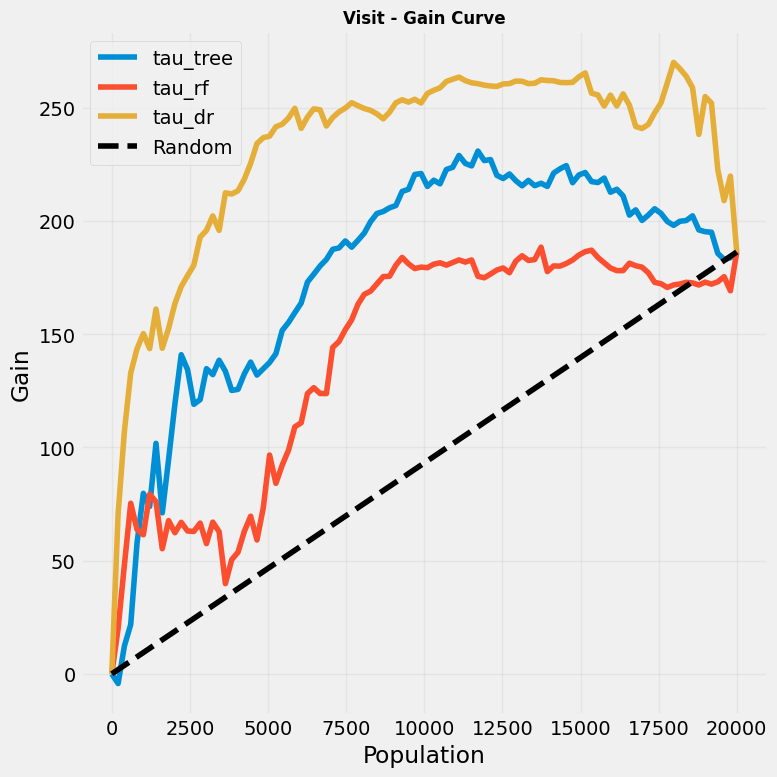

<Figure size 800x500 with 0 Axes>

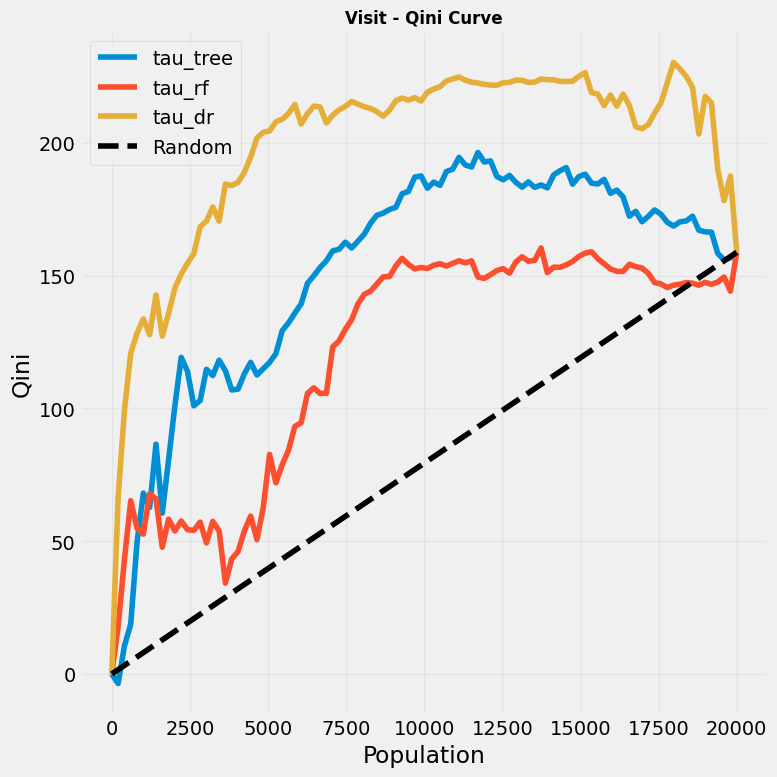

=== Conversion After Visit Uplift Î∂ÑÏÑù ===


<Figure size 800x500 with 0 Axes>

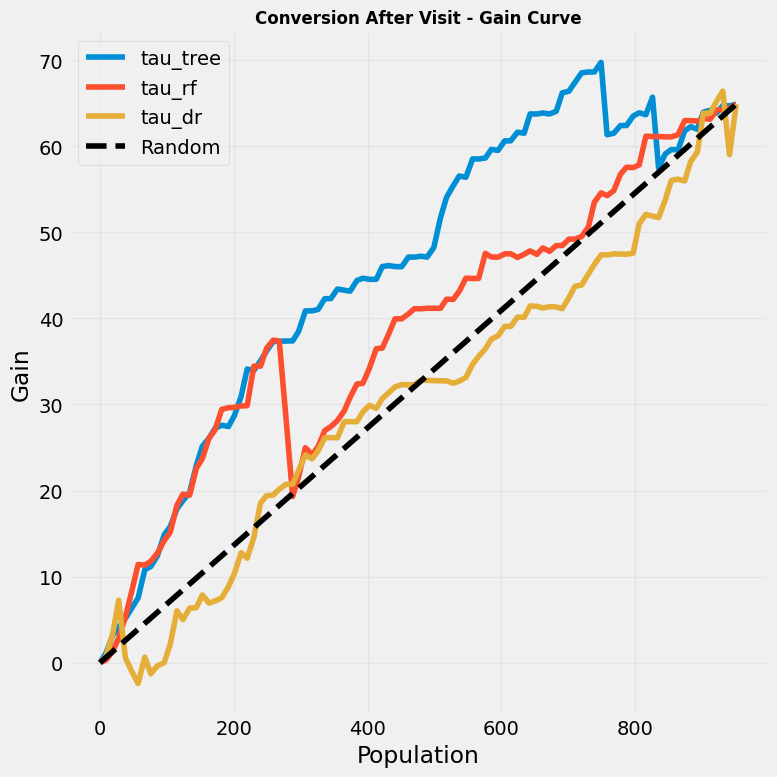

<Figure size 800x500 with 0 Axes>

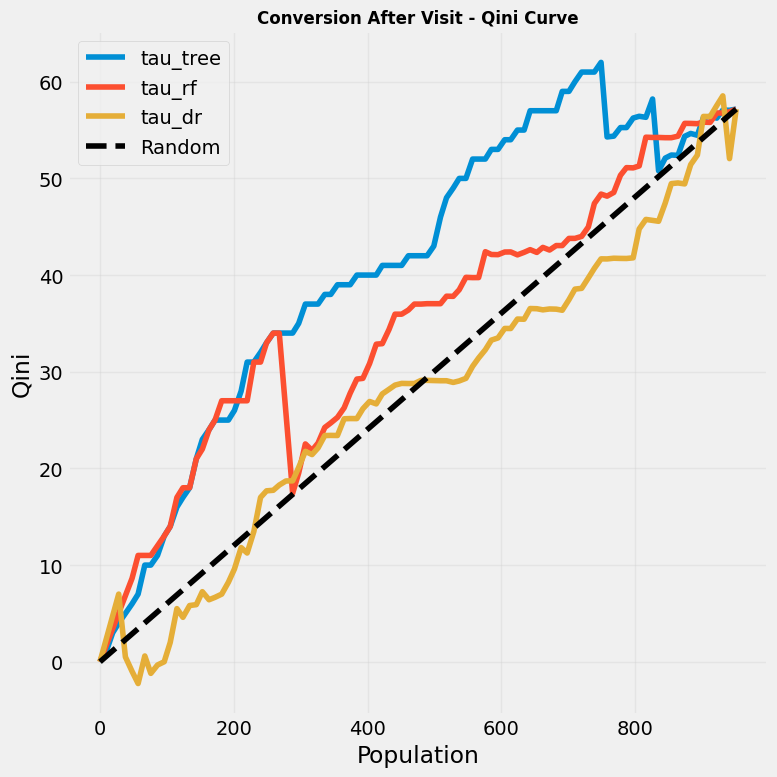

=== AUUC Score Î∂ÑÏÑù ===
AUUC Scores (Visit):
tau_tree    0.7641
tau_rf      0.6052
tau_dr      1.0000
dtype: float64

AUUC Scores (Conversion After Visit):
tau_tree    0.5630
tau_rf      0.4798
tau_dr      0.3782
dtype: float64


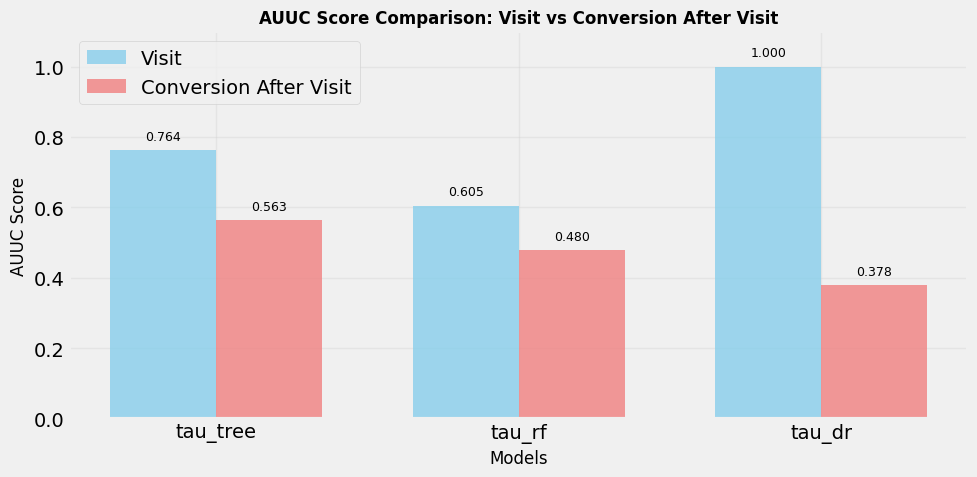

=== Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ ===

ÏÑ±Îä• ÏöîÏïΩ ÌÖåÏù¥Î∏î:
      Model  Visit_AUUC  Conversion_AUUC  Difference
0  tau_tree      0.7641           0.5630     -0.2011
1    tau_rf      0.6052           0.4798     -0.1255
2    tau_dr      1.0000           0.3782     -0.6218

ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏:
  Visit: tau_dr (AUUC: 1.0000)
  Conversion: tau_tree (AUUC: 0.5630)

* Î™®Îì† Ï†êÏàòÎäî 0-1 Î≤îÏúÑÎ°ú Ï†ïÍ∑úÌôîÎê®


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.metrics import plot_gain, plot_qini, auuc_score

# =============================================================================
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
# =============================================================================
print("=== Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ ===")

# Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞ 1Ï∞®Ïõê Î≥ÄÌôò
y_test_v_1d = np.array(y_test_v).flatten()
t_test_v_1d = np.array(t_test_v).flatten()
tau_hat_test_v_tree_1d = np.array(tau_hat_test_v_tree).flatten()
tau_hat_test_v_rf_1d = np.array(tau_hat_test_v_rf).flatten()

# Ï†ÑÌôò Îç∞Ïù¥ÌÑ∞ 1Ï∞®Ïõê Î≥ÄÌôò
y_test_c_1d = np.array(y_test_c).flatten()
t_test_c_1d = np.array(t_test_c).flatten()
tau_hat_test_c_tree_1d = np.array(tau_hat_test_c_tree).flatten()
tau_hat_test_c_rf_1d = np.array(tau_hat_test_c_rf).flatten()

# Î∞©Î¨∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
df_visit = pd.DataFrame({
    'conversion': y_test_v_1d,
    'treatment_assign': pd.Series(t_test_v_1d).map({'control': 0, 'treatment': 1}),
    'tau_tree': tau_hat_test_v_tree_1d,
    'tau_rf': tau_hat_test_v_rf_1d,
    'tau_dr': visit_effect_test
})

# Ï†ÑÌôò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
df_conversion = pd.DataFrame({
    'conversion': y_test_c_1d,
    'treatment_assign': pd.Series(t_test_c_1d).map({'control': 0, 'treatment': 1}),
    'tau_tree': tau_hat_test_c_tree_1d,
    'tau_rf': tau_hat_test_c_rf_1d,
    "tau_dr": conversion_effect_test
})

# =============================================================================
# 1. Visit Í∑∏ÎûòÌîÑÎì§
# =============================================================================
print("=== Visit Uplift Î∂ÑÏÑù ===")

# Visit - Gain Curve
plt.figure(figsize=(8, 5))
plot_gain(df_visit, outcome_col='conversion', treatment_col='treatment_assign',
          random_seed=42, n=100)
plt.title('Visit - Gain Curve', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visit - Qini Curve
plt.figure(figsize=(8, 5))
plot_qini(df_visit, outcome_col='conversion', treatment_col='treatment_assign',
          random_seed=42, n=100)
plt.title('Visit - Qini Curve', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# 2. Conversion After Visit Í∑∏ÎûòÌîÑÎì§
# =============================================================================
print("=== Conversion After Visit Uplift Î∂ÑÏÑù ===")

# Conversion - Gain Curve
plt.figure(figsize=(8, 5))
plot_gain(df_conversion, outcome_col='conversion', treatment_col='treatment_assign',
          random_seed=42, n=100)
plt.title('Conversion After Visit - Gain Curve', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Conversion - Qini Curve
plt.figure(figsize=(8, 5))
plot_qini(df_conversion, outcome_col='conversion', treatment_col='treatment_assign',
          random_seed=42, n=100)
plt.title('Conversion After Visit - Qini Curve', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# 3. AUUC Score Í≥ÑÏÇ∞ Î∞è ÏãúÍ∞ÅÌôî (Ï†ïÍ∑úÌôîÎêú Ï†êÏàòÎßå)
# =============================================================================
print("=== AUUC Score Î∂ÑÏÑù ===")

# ÏõêÎ≥∏ AUUC Ï†êÏàò Í≥ÑÏÇ∞
auuc_visit_raw = auuc_score(df_visit, outcome_col='conversion',
                            treatment_col='treatment_assign', normalize=True)
auuc_conversion_raw = auuc_score(df_conversion, outcome_col='conversion',
                                 treatment_col='treatment_assign', normalize=True)

# Ï†ÑÏ≤¥ ÏµúÎåÄÍ∞íÏúºÎ°ú Ï†ïÍ∑úÌôî
all_scores = pd.concat([auuc_visit_raw, auuc_conversion_raw])
max_val = all_scores.max()

# Ï†ïÍ∑úÌôîÎêú Ï†êÏàò
auuc_visit = auuc_visit_raw / max_val
auuc_conversion = auuc_conversion_raw / max_val

print("AUUC Scores (Visit):")
print(auuc_visit.round(4))
print("\nAUUC Scores (Conversion After Visit):")
print(auuc_conversion.round(4))

# Î™®Îç∏Î≥Ñ Ï†êÏàò Î¶¨Ïä§Ìä∏
models = list(auuc_visit.index)
visit_scores = [auuc_visit[model] for model in models]
conversion_scores = [auuc_conversion[model] for model in models]

# AUUC Score ÎπÑÍµê ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, visit_scores, width, label='Visit', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, conversion_scores, width, label='Conversion After Visit', alpha=0.8, color='lightcoral')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('AUUC Score', fontsize=12)
ax.set_title('AUUC Score Comparison: Visit vs Conversion After Visit', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

# Ï†ïÍ∑úÌôîÎêú Í∞í ÌëúÏãú
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. Í≤∞Í≥º ÏöîÏïΩ (Ï†ïÍ∑úÌôîÎêú Ï†êÏàòÎßå)
# =============================================================================
print("=== Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ ===")

summary_df = pd.DataFrame({
    'Model': models,
    'Visit_AUUC': visit_scores,
    'Conversion_AUUC': conversion_scores,
    'Difference': [conversion_scores[i] - visit_scores[i] for i in range(len(models))]
})

print("\nÏÑ±Îä• ÏöîÏïΩ ÌÖåÏù¥Î∏î:")
print(summary_df.round(4))
print(f"\nÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏:")
print(f"  Visit: {models[np.argmax(visit_scores)]} (AUUC: {max(visit_scores):.4f})")
print(f"  Conversion: {models[np.argmax(conversion_scores)]} (AUUC: {max(conversion_scores):.4f})")

print("\n* Î™®Îì† Ï†êÏàòÎäî 0-1 Î≤îÏúÑÎ°ú Ï†ïÍ∑úÌôîÎê®")

# Uplift Î™®Îç∏ ÏÑ±Îä• Î∂ÑÏÑù Î∞è Ï†ÑÎûµÏ†Å Ìï¥ÏÑù

## 1. AUUC Ï†êÏàò ÎπÑÍµê (Area Under the Uplift Curve)

### Visit Uplift ÏÑ±Îä•

| Î™®Îç∏                     | AUUC Ï†êÏàò | ÏàúÏúÑ |
|--------------------------|-----------|------|
| DR-Learner (`tau_dr`)    | 1.0000    | 1ÏúÑ  |
| Tree Î™®Îç∏ (`tau_tree`)   | 0.7641    | 2ÏúÑ  |
| Random Forest (`tau_rf`) | 0.6052    | 3ÏúÑ  |

### Conversion After Visit ÏÑ±Îä•

| Î™®Îç∏                     | AUUC Ï†êÏàò | ÏàúÏúÑ |
|--------------------------|-----------|------|
| Tree Î™®Îç∏ (`tau_tree`)   | 0.5630    | 1ÏúÑ  |
| Random Forest (`tau_rf`) | 0.4798    | 2ÏúÑ  |
| DR-Learner (`tau_dr`)    | 0.3782    | 3ÏúÑ  |

---

## 2. Î™®Îç∏Î≥Ñ ÏÑ±Îä• ÌäπÏÑ± Î∂ÑÏÑù

### DR-Learner (Doubly Robust)
- VisitÏóêÏÑú Îß§Ïö∞ Îõ∞Ïñ¥ÎÇú ÏÑ±Îä•ÏùÑ Î≥¥Ïù¥Î©∞ AUUC Ï†êÏàò 1.0000ÏúºÎ°ú Í∞ÄÏû• Ïö∞ÏàòÌï®
- Î∞òÎ©¥ ConversionÏóêÏÑúÎäî AUUC Ï†êÏàò 0.3782Î°ú ÌïòÏúÑÍ∂å
- Visit ÎåÄÎπÑ Conversion ÏÑ±Îä• Ï∞®Ïù¥: -0.6218
- **Ìï¥ÏÑù**: Î∞©Î¨∏ÏùÑ Ïú†ÎèÑÌïòÎäî Îç∞ÏóêÎäî Îß§Ïö∞ Ìö®Í≥ºÏ†ÅÏù¥ÎÇò, Î∞©Î¨∏ Ïù¥ÌõÑ Ïã§Ï†ú Ï†ÑÌôòÏúºÎ°úÏùò Ïó∞Í≤∞ÏùÄ Ï†úÌïúÏ†ÅÏûÑ

### Tree Î™®Îç∏
- VisitÏóêÏÑú AUUC 0.7641Î°ú Ï§ëÏÉÅÏúÑÍ∂å
- ConversionÏóêÏÑúÎäî AUUC 0.5630ÏúºÎ°ú Í∞ÄÏû• Îõ∞Ïñ¥ÎÇú ÏÑ±Îä•
- Visit ÎåÄÎπÑ Conversion ÏÑ±Îä• Ï∞®Ïù¥: -0.2011
- **Ìï¥ÏÑù**: Ï†ÑÌôòÏú® Ï†úÍ≥†Ïóê Í∞ÄÏû• Ìö®Í≥ºÏ†ÅÏù∏ Î™®Îç∏Î°ú, Î∞©Î¨∏ Ïù¥ÌõÑ Íµ¨Îß§ Ïú†ÎèÑÏóê Í∞ïÏ†ê

### Random Forest
- VisitÏóêÏÑú AUUC 0.6052, ConversionÏóêÏÑúÎäî 0.4798ÏúºÎ°ú Ï§ëÍ∞Ñ ÏàòÏ§ÄÏùò ÏÑ±Îä•
- ÏÑ±Îä• Ï∞®Ïù¥: -0.1255Î°ú Í∞ÄÏû• ÏûëÏùå
- **Ìï¥ÏÑù**: Î∞©Î¨∏Í≥º Ï†ÑÌôò Î™®ÎëêÏóêÏÑú ÏïàÏ†ïÏ†ÅÏù∏ ÏÑ±Îä•ÏùÑ Î≥¥Ïù¥ÎÇò, ÎëêÎìúÎü¨ÏßÑ Ïû•Ï†êÏùÄ Î∂ÄÏ°±

---

## 3. ÎßàÏºÄÌåÖ Ï†ÑÎûµÏóê Îî∞Î•∏ Î™®Îç∏ ÏÑ†ÌÉù Î∞©Ïïà

### 3.1 Î∞©Î¨∏ Ìä∏ÎûòÌîΩ Ï¶ùÎåÄÍ∞Ä Ï£ºÎ™©ÌëúÏù∏ Í≤ΩÏö∞
- **DR-Learner Ï∂îÏ≤ú**
- Visit Uplift AUUC Ï†êÏàò 1.0000ÏúºÎ°ú Í∞ÄÏû• ÎÜíÏùå
- Î∏åÎûúÎìú Ïù∏ÏßÄÎèÑ Ï†úÍ≥†, ÏõπÏÇ¨Ïù¥Ìä∏ Ïú†ÏûÖ ÌôïÎåÄ Îì±Ïùò Ï∫†ÌéòÏù∏Ïóê Ï†ÅÌï©

### 3.2 Ïã§Ï†ú Ï†ÑÌôò(Îß§Ï∂ú) Í∑πÎåÄÌôîÍ∞Ä Ï£ºÎ™©ÌëúÏù∏ Í≤ΩÏö∞
- **Tree Î™®Îç∏ Ï∂îÏ≤ú**
- Conversion Uplift AUUC Ï†êÏàò 0.5630ÏúºÎ°ú Í∞ÄÏû• Îõ∞Ïñ¥ÎÇ®
- Íµ¨Îß§ Ï†ÑÌôò Ï§ëÏã¨Ïùò ÌçºÌè¨Î®ºÏä§ ÎßàÏºÄÌåÖÏóê Ìö®Í≥ºÏ†Å

### 3.3 Í∑†ÌòïÏû°Ìûå ÏÑ±Í≥ºÎ•º ÏõêÌïòÎäî Í≤ΩÏö∞
- **Tree Î™®Îç∏ ÎòêÎäî Random Forest Í≥†Î†§ Í∞ÄÎä•**
- Tree Î™®Îç∏ÏùÄ Ï†ÑÌôò ÏÑ±Îä• Ï§ëÏã¨Ïù¥ÏßÄÎßå Î∞©Î¨∏ upliftÎèÑ Ïö∞Ïàò
- Random ForestÎäî Îëê ÏßÄÌëúÏóêÏÑú Î™®Îëê ÏïàÏ†ïÏ†ÅÏù∏ ÌèâÍ∑† ÏàòÏ§Ä Ïù¥ÏÉÅÏùò ÏÑ±Í≥º

---

## 4. ÏòàÏÇ∞ Î∞∞Î∂Ñ Î∞è Ïö¥ÏòÅ Ï†ÑÎûµ

### Îã®Í≥ÑÏ†Å Ï†ëÍ∑º Ï†ÑÎûµ
1. **1Îã®Í≥Ñ**: DR-LearnerÎ•º ÌÜµÌï¥ Î∞©Î¨∏Ïûê Ïàò ÌôïÎ≥¥
2. **2Îã®Í≥Ñ**: Tree Î™®Îç∏ÏùÑ ÌôúÏö©ÌïòÏó¨ Ï†ÑÌôòÎ•† Í∑πÎåÄÌôî
3. ÏÉÅÌô©Ïóê Îî∞Îùº Îëê Î™®Îç∏ÏùÑ Ï†ÅÏ†àÌûà Ï†ÑÌôò¬∑Ï°∞Ìï©ÌïòÏó¨ Ïú†Ïó∞ÌïòÍ≤å Ïö¥ÏòÅ

---

## 5. ÏÑ±Îä• Ï∞®Ïù¥ Î∂ÑÏÑù Î∞è Ï†ÑÎûµÏ†Å Í≥†Î†§ÏÇ¨Ìï≠

- DR-LearnerÏùò Visit ÏÑ±Îä•ÏùÄ Tree Î™®Îç∏ ÎåÄÎπÑ ÏïΩ **31% Ïö∞Ïàò** (1.0000 vs 0.7641)
- Î∞òÎåÄÎ°ú Tree Î™®Îç∏Ïùò Conversion ÏÑ±Îä•ÏùÄ DR-Learner ÎåÄÎπÑ ÏïΩ **49% Ïö∞Ïàò** (0.5630 vs 0.3782)

Ïù¥Îü¨Ìïú ÏÑ±Îä• Ï∞®Ïù¥Îäî ÎßàÏºÄÌåÖ Ï†ÑÎûµ ÏàòÎ¶Ω Î∞è ÏòàÏÇ∞ Î∞∞Î∂Ñ Ïãú Ï§ëÏöîÌïú Í∑ºÍ±∞Í∞Ä ÎêòÎ©∞, Î™©Ï†ÅÏóê Îî∞Îùº Î™®Îç∏ÏùÑ Íµ¨Î∂Ñ Ï†ÅÏö©ÌïòÍ±∞ÎÇò ÌÜµÌï© Ï†ÑÎûµÏùÑ ÌôúÏö©ÌïòÎäî Í≤ÉÏù¥ Î∞îÎûåÏßÅÌïòÎã§.

**Ï∞∏Í≥†**: Î™®Îì† AUUC Ï†êÏàòÎäî 0-1 Î≤îÏúÑÎ°ú Ï†ïÍ∑úÌôîÎêòÏóàÏúºÎ©∞, ÏÉÅÎåÄÏ†Å ÏÑ±Îä• ÎπÑÍµêÎäî Ïó¨Ï†ÑÌûà Ïú†Ìö®Ìï®.